1. Installasi library yang diperlukan untuk proses wrangling

In [73]:
!pip install pdfplumber


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [74]:
!pip install matplotlib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# A. Teknik penggambilan dan integrasi data


## 1. Men-Scrapping data upah minimum provinsi berdarkan website Catapa

In [75]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re


def rupiah_to_int(s):
    s = s.strip()
    s = s.replace("Rp", "").replace(".", "").replace(",", "")
    try:
        return int(s)
    except:
        return None

def norm_prov(prov):
    prov = prov.strip()
    prov = prov.replace("Daerah Istimewa Yogyakarta", "D.I. Yogyakarta")
    return prov


url = "https://catapa.com/blog/daftar-lengkap-kenaikan-ump-2024-di-38-provinsi-indonesia"
resp = requests.get(url)
resp.raise_for_status()
soup = BeautifulSoup(resp.text, "html.parser")


paras = soup.find_all("p")
text_lines = []
for p in paras:
    text_lines.extend(p.get_text().split("\n"))


pattern = re.compile(r"^([A-Za-z\s\.\-]+)\s*:\s*Rp([\d\.,]+)")

data = []
for line in text_lines:
    m = pattern.match(line)
    if m:
        prov = norm_prov(m.group(1))
        val = rupiah_to_int(m.group(2))
        if prov and val is not None:
            data.append((prov, val))


df_ump = pd.DataFrame(data, columns=["Provinsi", "UMP_2024"])

print("Jumlah provinsi hasil scraping:", len(df_ump))
print(df_ump["Provinsi"].unique())


df_ump.to_csv("ump_2024.csv", index=False)
print("Nama file ump_2024_.csv")

df_ump.head(38)


Jumlah provinsi hasil scraping: 38
['Aceh' 'Sumatera Utara' 'Sumatera Barat' 'Kepulauan Riau'
 'Bangka Belitung' 'Riau' 'Bengkulu' 'Sumatera Selatan' 'Jambi' 'Lampung'
 'Banten' 'DKI Jakarta' 'Jawa Barat' 'Jawa Tengah' 'D.I. Yogyakarta'
 'Jawa Timur' 'Bali' 'Nusa Tenggara Barat' 'Nusa Tenggara Timur'
 'Kalimantan Barat' 'Kalimantan Selatan' 'Kalimantan Tengah'
 'Kalimantan Timur' 'Kalimantan Utara' 'Sulawesi Barat' 'Gorontalo'
 'Sulawesi Tengah' 'Sulawesi Utara' 'Sulawesi Selatan' 'Sulawesi Tenggara'
 'Maluku' 'Maluku Utara' 'Papua' 'Papua Barat' 'Papua Tengah'
 'Papua Pegunungan' 'Papua Barat Daya' 'Papua Selatan']
Nama file ump_2024_.csv


,Provinsi,UMP_2024
0,Aceh,3460672
1,Sumatera Utara,2809915
2,Sumatera Barat,2811499
3,Kepulauan Riau,3402492
4,Bangka Belitung,3640000
5,Riau,3294625
6,Bengkulu,2507079
7,Sumatera Selatan,3456874
8,Jambi,3037121
9,Lampung,2716497


## 2. Mengekstark PDF laporan BPS yang berisikan data konsumsi kalori perkapita tiap kuintil

In [76]:
import pdfplumber
import pandas as pd

with pdfplumber.open("1737605184791-81-23.-konsumsi-kalori-dan-protein-penduduk-indonesia-dan-provinsi--maret-2024.pdf") as pdf:
    page = pdf.pages[29]
    table = page.extract_table()

df_kalori = pd.DataFrame(table[1:], columns=table[0])

print(df_kalori)


      Provinsi\nProvince Kuintil Pengeluaran\nQuintile of Expenditure  \
0                   None                               Pertama\nFirst   
1                    (1)                                          (2)   
2                   Aceh                                     1.559,07   
3         Sumatera Utara                                     1.648,10   
4         Sumatera Barat                                     1.645,65   
5                   Riau                                     1.573,72   
6                  Jambi                                     1.588,60   
7       Sumatera Selatan                                     1.742,56   
8               Bengkulu                                     1.661,21   
9                Lampung                                     1.632,01   
10  Kep. Bangka Belitung                                     1.596,43   
11        Kepulauan Riau                                     1.660,66   
12                                                 

### 2.1. Membersihkan data konsumsi kalori perkapita tiap kuintil supaya lebih mudah dalam merge data

In [77]:
import pandas as pd
import numpy as np
import re

df_clean = df_kalori.copy()

# 1. Hapus baris kosong total
df_clean = df_clean.replace("", np.nan)
df_clean = df_clean.dropna(how="all")

# 2. Set header manual
df_clean.columns = [
    "Provinsi",
    "Kuintil Pertama",
    "Kuintil Kedua",
    "Kuintil Ketiga",
    "Kuintil Keempat",
    "Kuintil Kelima"
]

# 3. Drop baris "(1)" "(2)"
df_clean = df_clean[~df_clean["Provinsi"].str.contains(r"\(", na=False)]

# 4. Bersihkan kolom angka: HAPUS SEMUA HURUF dan simbol selain angka/.,,
angka_cols = ["Kuintil Pertama", "Kuintil Kedua", "Kuintil Ketiga",
              "Kuintil Keempat", "Kuintil Kelima"]

for col in angka_cols:
    df_clean[col] = df_clean[col].astype(str)
    df_clean[col] = df_clean[col].apply(lambda x: re.sub(r"[A-Za-z/\\:\n\s]", "", x))
    # sekarang hanya tersisa "1661,76" atau "1.660,82"

# 5. Convert format Eropa
def europe(x):
    x = x.replace(".", "").replace(",", ".")
    try:
        return float(x)
    except:
        return np.nan

for col in angka_cols:
    df_clean[col] = df_clean[col].apply(europe)

# 6. Rapikan nama provinsi
df_clean["Provinsi"] = df_clean["Provinsi"].str.replace(r"\d+", "", regex=True)
df_clean["Provinsi"] = df_clean["Provinsi"].str.replace(r"\s+", " ", regex=True).str.strip()
df_clean = df_clean[df_clean["Provinsi"].str.len() > 2]

df_clean = df_clean.reset_index(drop=True)

df_clean_kalori = df_clean
df_clean_kalori.head(38)

,Provinsi,Kuintil Pertama,Kuintil Kedua,Kuintil Ketiga,Kuintil Keempat,Kuintil Kelima
0,Aceh,1559.07,1863.50,2038.54,2228.84,2574.43
1,Sumatera Utara,1648.10,1898.96,2070.20,2282.54,2568.40
2,Sumatera Barat,1645.65,1921.83,2103.17,2265.57,2494.01
3,Riau,1573.72,1850.46,2062.50,2214.23,2539.02
4,Jambi,1588.60,1837.40,2018.34,2225.61,2543.68
5,Sumatera Selatan,1742.56,1970.37,2166.57,2405.55,2670.34
6,Bengkulu,1661.21,1943.68,2030.50,2243.65,2420.84
7,Lampung,1632.01,1908.12,2087.03,2300.06,2554.05
8,Kep. Bangka Belitung,1596.43,1890.34,2013.61,2261.71,2530.82
9,Kepulauan Riau,1660.66,1963.96,2070.37,2245.82,2297.70


## 3. Read CSV untuk data ketiga yang berisikan prevelensi kesehatan tiap provinsi

In [78]:
df_kesehatan = pd.read_csv("tabel_gizi_lengkap_part2.csv")
df_kesehatan.head(38)

,Provinsi,Stunting,Wasting,Kelebihan berat badan,Anak 5-12 tahun,Remaja 13-15 tahun,Remaja 16-18 tahun,Dewasa >18 tahun,Kerawanan pangan
0,Aceh,29.3,13.6,3.5,17.2,15.3,12.1,39.9,4.7
1,Banten,23.9,10.2,4.9,19.3,15.6,10.5,36.9,5.76
2,DKI Jakarta,17.6,10.1,6.7,27.3,23.3,19.2,48.0,3.36
3,Gorontalo,26.8,12.7,4.4,17.0,14.3,14.8,42.5,5.96
4,Jawa Barat,21.7,6.3,3.9,18.4,17.0,13.1,39.8,4.9
5,Kalimantan Barat,24.5,13.3,5.5,20.6,15.5,9.9,30.7,5.02
6,Kalimantan Selatan,24.7,12.4,4.8,20.2,14.5,12.9,33.5,3.69
7,Kalimantan Tengah,23.5,9.0,7.2,21.4,17.1,12.5,36.5,3.73
8,Kalimantan Timur,22.8,10.1,4.7,21.4,18.6,15.7,43.2,3.23
9,Kalimantan Utara,17.4,8.7,4.4,24.2,15.8,9.9,40.2,3.65


### 3.1 Mengganti nama kolom agar lebih mudah dimengerti

In [79]:
#GANTI NAMA KOLOM
df_kesehatan.rename(columns={
    'Anak 5-12 tahun': 'Kelebihan BB Anak 5-12 tahun',
    'Remaja 13-15 tahun': 'Kelebihan BB Remaja 13-15 tahun',
    'Remaja 16-18 tahun': 'Kelebihan BB Remaja 16-18 tahun',
    'Dewasa >18 tahun': 'Kelebihan BB Dewasa >18 tahun'
}, inplace=True)
df_kesehatan.head()

,Provinsi,Stunting,Wasting,Kelebihan berat badan,Kelebihan BB Anak 5-12 tahun,Kelebihan BB Remaja 13-15 tahun,Kelebihan BB Remaja 16-18 tahun,Kelebihan BB Dewasa >18 tahun,Kerawanan pangan
0,Aceh,29.3,13.6,3.5,17.2,15.3,12.1,39.9,4.7
1,Banten,23.9,10.2,4.9,19.3,15.6,10.5,36.9,5.76
2,DKI Jakarta,17.6,10.1,6.7,27.3,23.3,19.2,48.0,3.36
3,Gorontalo,26.8,12.7,4.4,17.0,14.3,14.8,42.5,5.96
4,Jawa Barat,21.7,6.3,3.9,18.4,17.0,13.1,39.8,4.9


## 4. Cleaning nama provinsi agar sesuai provinsi dataset ump, dataset kalori, dan dataset kesehatan

In [80]:
set_ump = set(df_ump["Provinsi"])
set_kalori = set(df_clean_kalori["Provinsi"])
set_kesehatan = set(df_kesehatan["Provinsi"])

print("UMP:", set_ump)
print("Konsumsi:", set_kalori)
print("Kesehatan:", set_kesehatan)


UMP: {'Papua Barat Daya', 'Papua Tengah', 'Maluku Utara', 'Kepulauan Riau', 'Sulawesi Utara', 'Sulawesi Tenggara', 'Jawa Timur', 'Jawa Barat', 'Sumatera Utara', 'Bangka Belitung', 'Bali', 'Sulawesi Tengah', 'Maluku', 'Sumatera Selatan', 'D.I. Yogyakarta', 'Papua', 'Kalimantan Utara', 'Lampung', 'Nusa Tenggara Timur', 'Nusa Tenggara Barat', 'Papua Barat', 'Kalimantan Barat', 'Papua Selatan', 'Kalimantan Tengah', 'Riau', 'Kalimantan Selatan', 'Jambi', 'Aceh', 'Jawa Tengah', 'Banten', 'Kalimantan Timur', 'Sulawesi Selatan', 'Gorontalo', 'Sumatera Barat', 'Sulawesi Barat', 'DKI Jakarta', 'Papua Pegunungan', 'Bengkulu'}
Konsumsi: {'Maluku Utara', 'Kepulauan Riau', 'Sulawesi Utara', 'Sulawesi Tenggara', 'Kep. Bangka Belitung', 'Jawa Timur', 'Jawa Barat', 'Sumatera Utara', 'Bali', 'Indonesia', 'Sulawesi Tengah', 'Maluku', 'Sumatera Selatan', 'Papua', 'Kalimantan Utara', 'Lampung', 'Nusa Tenggara Timur', 'Nusa Tenggara Barat', 'Papua Barat', 'Kalimantan Barat', 'Kalimantan Tengah', 'Riau', 'Ka

In [81]:
print("Tidak ada di konsumsi:", set_ump - set_kalori)
print("Tidak ada di kesehatan:", set_ump - set_kesehatan)
print("Kesehatan tidak ada di UMP:", set_kesehatan - set_ump)


Tidak ada di konsumsi: {'Papua Barat Daya', 'Papua Tengah', 'D.I. Yogyakarta', 'Bangka Belitung', 'Papua Pegunungan', 'Papua Selatan'}
Tidak ada di kesehatan: {'D.I. Yogyakarta', 'Maluku', 'Bangka Belitung'}
Kesehatan tidak ada di UMP: {'Maluku ', 'INDONESIA', 'DI Yogyakarta'}


In [82]:
#menghapus spasi awal dan akhir kolom provinsi
for df in [df_ump, df_clean_kalori, df_kesehatan]:
    df["Provinsi"] = df["Provinsi"].str.strip()

In [83]:
#Mengubah nama provinsi yang tidak sesuai
mapping = {
    "DI Yogyakarta": "D.I. Yogyakarta",
    "D I Yogyakarta": "D.I. Yogyakarta",
    "Maluku ": "Maluku",
    "Kep. Bangka Belitung": "Bangka Belitung", 
}
for df in [df_ump, df_clean_kalori, df_kesehatan]:
    df["Provinsi"] = df["Provinsi"].replace(mapping)

In [84]:
set_ump = set(df_ump["Provinsi"])
set_kalori = set(df_clean_kalori["Provinsi"])
set_kesehatan = set(df_kesehatan["Provinsi"])

print("Provinsi UMP yg Tidak ada di konsumsi:", set_ump - set_kalori)
print("Provinsi UMP Tidak ada di kesehatan:", set_ump - set_kesehatan)
print("Provinsi UMP Konsumsi yg tidak ada di kesehatan:", set_kalori - set_kesehatan)


Provinsi UMP yg Tidak ada di konsumsi: {'Papua Barat Daya', 'Papua Tengah', 'Papua Selatan', 'Papua Pegunungan'}
Provinsi UMP Tidak ada di kesehatan: {'Bangka Belitung'}
Provinsi UMP Konsumsi yg tidak ada di kesehatan: {'Bangka Belitung', 'Indonesia'}


## 5. Integrasi data dengan melakukan merge left seluruh data set berdasarkan provinsi sebagai key

In [85]:
df_gabungan = df_ump.merge(df_clean_kalori, on="Provinsi", how="left").merge(df_kesehatan, on="Provinsi", how="left")
df_gabungan.head(38)

,Provinsi,UMP_2024,Kuintil Pertama,Kuintil Kedua,Kuintil Ketiga,Kuintil Keempat,Kuintil Kelima,Stunting,Wasting,Kelebihan berat badan,Kelebihan BB Anak 5-12 tahun,Kelebihan BB Remaja 13-15 tahun,Kelebihan BB Remaja 16-18 tahun,Kelebihan BB Dewasa >18 tahun,Kerawanan pangan
0,Aceh,3460672,1559.07,1863.50,2038.54,2228.84,2574.43,29.3,13.6,3.5,17.2,15.3,12.1,39.9,4.7
1,Sumatera Utara,2809915,1648.10,1898.96,2070.20,2282.54,2568.40,18.9,7.9,3.5,18.3,14.4,10.8,40.9,5.19
2,Sumatera Barat,2811499,1645.65,1921.83,2103.17,2265.57,2494.01,NaN,NaN,NaN,16.2,14.7,9.5,NaN,NaN
3,Kepulauan Riau,3402492,1660.66,1963.96,2070.37,2245.82,2297.70,16.8,6.3,4.6,21.6,16.5,16.0,44.2,4.58
4,Bangka Belitung,3640000,1596.43,1890.34,2013.61,2261.71,2530.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Riau,3294625,1573.72,1850.46,2062.50,2214.23,2539.02,NaN,NaN,NaN,20.1,16.4,10.4,40.8,NaN
6,Bengkulu,2507079,1661.21,1943.68,2030.50,2243.65,2420.84,NaN,NaN,NaN,23.6,15.2,7.7,NaN,NaN
7,Sumatera Selatan,3456874,1742.56,1970.37,2166.57,2405.55,2670.34,20.3,9.7,5.1,18.3,13.1,8.2,31.2,4.42
8,Jambi,3037121,1588.60,1837.40,2018.34,2225.61,2543.68,NaN,NaN,NaN,19.2,10.5,5.2,NaN,NaN
9,Lampung,2716497,1632.01,1908.12,2087.03,2300.06,2554.05,14.9,7.3,3.4,20.2,11.5,8.2,33.4,5.12


# B. Data Cleaning Setelah Merge Data


In [86]:
df_gabungan.dtypes

Provinsi                            object
UMP_2024                             int64
Kuintil Pertama                    float64
Kuintil Kedua                      float64
Kuintil Ketiga                     float64
Kuintil Keempat                    float64
Kuintil Kelima                     float64
Stunting                           float64
Wasting                            float64
Kelebihan berat badan              float64
Kelebihan BB Anak 5-12 tahun       float64
Kelebihan BB Remaja 13-15 tahun    float64
Kelebihan BB Remaja 16-18 tahun    float64
Kelebihan BB Dewasa >18 tahun      float64
Kerawanan pangan                    object
dtype: object

## 1. Mengubah kolom angka menjadi format numeric dan mengubah object menjadi nilai NaN

In [87]:
#mengubah dan membersihkan kolom angka ke numeric
kolom = [
    "Kuintil Pertama", "Kuintil Kedua", "Kuintil Ketiga",
    "Kuintil Keempat", "Kuintil Kelima",
    "Stunting", "Wasting", "Kelebihan berat badan",
    "Kelebihan BB Anak 5-12 tahun",	"Kelebihan BB Remaja 13-15 tahun",
    "Kelebihan BB Remaja 16-18 tahun",	"Kelebihan BB Dewasa >18 tahun",
    "Kerawanan pangan"
]

for col in kolom:
    df_gabungan[col] = pd.to_numeric(df_gabungan[col], errors="coerce")

df_gabungan.dtypes

Provinsi                            object
UMP_2024                             int64
Kuintil Pertama                    float64
Kuintil Kedua                      float64
Kuintil Ketiga                     float64
Kuintil Keempat                    float64
Kuintil Kelima                     float64
Stunting                           float64
Wasting                            float64
Kelebihan berat badan              float64
Kelebihan BB Anak 5-12 tahun       float64
Kelebihan BB Remaja 13-15 tahun    float64
Kelebihan BB Remaja 16-18 tahun    float64
Kelebihan BB Dewasa >18 tahun      float64
Kerawanan pangan                   float64
dtype: object

In [88]:
df_gabungan = df_gabungan.sort_values('Provinsi').reset_index(drop=True)
df_gabungan.head(40)

,Provinsi,UMP_2024,Kuintil Pertama,Kuintil Kedua,Kuintil Ketiga,Kuintil Keempat,Kuintil Kelima,Stunting,Wasting,Kelebihan berat badan,Kelebihan BB Anak 5-12 tahun,Kelebihan BB Remaja 13-15 tahun,Kelebihan BB Remaja 16-18 tahun,Kelebihan BB Dewasa >18 tahun,Kerawanan pangan
0,Aceh,3460672,1559.07,1863.50,2038.54,2228.84,2574.43,29.3,13.6,3.5,17.2,15.3,12.1,39.9,4.70
1,Bali,2813672,1918.83,2175.64,2266.56,2366.14,2590.63,NaN,NaN,NaN,26.7,20.0,13.2,39.8,NaN
2,Bangka Belitung,3640000,1596.43,1890.34,2013.61,2261.71,2530.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Banten,2727812,1752.49,2053.64,2205.32,2428.25,2597.54,23.9,10.2,4.9,19.3,15.6,10.5,36.9,5.76
4,Bengkulu,2507079,1661.21,1943.68,2030.50,2243.65,2420.84,NaN,NaN,NaN,23.6,15.2,7.7,NaN,NaN
5,D.I. Yogyakarta,2125897,1661.76,1935.91,2072.51,2181.61,2412.39,NaN,NaN,NaN,21.6,25.6,19.1,39.0,NaN
6,DKI Jakarta,5067381,1665.07,1987.44,2191.06,2417.09,2528.61,17.6,10.1,6.7,27.3,23.3,19.2,48.0,3.36
7,Gorontalo,3025100,1635.97,1864.76,2014.22,2118.37,2347.49,26.8,12.7,4.4,17.0,14.3,14.8,42.5,5.96
8,Jambi,3037121,1588.60,1837.40,2018.34,2225.61,2543.68,NaN,NaN,NaN,19.2,10.5,5.2,NaN,NaN
9,Jawa Barat,2057495,1682.32,1947.48,2128.39,2293.57,2499.94,21.7,6.3,3.9,18.4,17.0,13.1,39.8,4.90


In [89]:
df_gabungan['Provinsi'].duplicated().sum()

np.int64(0)

In [90]:
df_gabungan[df['Provinsi'].isna()]

,Provinsi,UMP_2024,Kuintil Pertama,Kuintil Kedua,Kuintil Ketiga,Kuintil Keempat,Kuintil Kelima,Stunting,Wasting,Kelebihan berat badan,Kelebihan BB Anak 5-12 tahun,Kelebihan BB Remaja 13-15 tahun,Kelebihan BB Remaja 16-18 tahun,Kelebihan BB Dewasa >18 tahun,Kerawanan pangan


## 2. Mengatasi Nilai NaN

  ### 2.1.Menghapus Baris dan Kolom jika nilai NaN lebih dari 50%


In [91]:
df_gabungan.isna().sum()

Provinsi                            0
UMP_2024                            0
Kuintil Pertama                     4
Kuintil Kedua                       4
Kuintil Ketiga                      4
Kuintil Keempat                     4
Kuintil Kelima                      4
Stunting                           14
Wasting                            14
Kelebihan berat badan              14
Kelebihan BB Anak 5-12 tahun        1
Kelebihan BB Remaja 13-15 tahun     1
Kelebihan BB Remaja 16-18 tahun     1
Kelebihan BB Dewasa >18 tahun       8
Kerawanan pangan                   18
dtype: int64

In [92]:
#PRESENTASE NAN KOLOM
persentase_nan_kolom = df_gabungan.isna().mean() * 100
print(persentase_nan_kolom)

#PERSENTASE NAN BARIS
persentase_nan_baris = df_gabungan.isna().mean(axis=1) * 100
print(persentase_nan_baris)

Provinsi                            0.000000
UMP_2024                            0.000000
Kuintil Pertama                    10.526316
Kuintil Kedua                      10.526316
Kuintil Ketiga                     10.526316
Kuintil Keempat                    10.526316
Kuintil Kelima                     10.526316
Stunting                           36.842105
Wasting                            36.842105
Kelebihan berat badan              36.842105
Kelebihan BB Anak 5-12 tahun        2.631579
Kelebihan BB Remaja 13-15 tahun     2.631579
Kelebihan BB Remaja 16-18 tahun     2.631579
Kelebihan BB Dewasa >18 tahun      21.052632
Kerawanan pangan                   47.368421
dtype: float64
0      0.000000
1     26.666667
2     53.333333
3      0.000000
4     33.333333
5     26.666667
6      0.000000
7      0.000000
8     33.333333
9      0.000000
10    26.666667
11    26.666667
12     0.000000
13     0.000000
14     0.000000
15     0.000000
16     0.000000
17     0.000000
18     0.000000
19    

In [93]:
#MENGHASPUS BATRIS DAN KOLOM DENGAN NAN <= 50%
# Hapus kolom < 50% NaN
df_gabungan = df_gabungan.loc[:, df_gabungan.isna().mean() < 0.5]

# Hapus kolom < 50% NaN
df_gabungan = df_gabungan.loc[df_gabungan.isna().mean(axis=1) < 0.5]


# Cek hasilnya
print(df_gabungan.shape)

df_gabungan.head(38)

(37, 15)


,Provinsi,UMP_2024,Kuintil Pertama,Kuintil Kedua,Kuintil Ketiga,Kuintil Keempat,Kuintil Kelima,Stunting,Wasting,Kelebihan berat badan,Kelebihan BB Anak 5-12 tahun,Kelebihan BB Remaja 13-15 tahun,Kelebihan BB Remaja 16-18 tahun,Kelebihan BB Dewasa >18 tahun,Kerawanan pangan
0,Aceh,3460672,1559.07,1863.50,2038.54,2228.84,2574.43,29.3,13.6,3.5,17.2,15.3,12.1,39.9,4.70
1,Bali,2813672,1918.83,2175.64,2266.56,2366.14,2590.63,NaN,NaN,NaN,26.7,20.0,13.2,39.8,NaN
3,Banten,2727812,1752.49,2053.64,2205.32,2428.25,2597.54,23.9,10.2,4.9,19.3,15.6,10.5,36.9,5.76
4,Bengkulu,2507079,1661.21,1943.68,2030.50,2243.65,2420.84,NaN,NaN,NaN,23.6,15.2,7.7,NaN,NaN
5,D.I. Yogyakarta,2125897,1661.76,1935.91,2072.51,2181.61,2412.39,NaN,NaN,NaN,21.6,25.6,19.1,39.0,NaN
6,DKI Jakarta,5067381,1665.07,1987.44,2191.06,2417.09,2528.61,17.6,10.1,6.7,27.3,23.3,19.2,48.0,3.36
7,Gorontalo,3025100,1635.97,1864.76,2014.22,2118.37,2347.49,26.8,12.7,4.4,17.0,14.3,14.8,42.5,5.96
8,Jambi,3037121,1588.60,1837.40,2018.34,2225.61,2543.68,NaN,NaN,NaN,19.2,10.5,5.2,NaN,NaN
9,Jawa Barat,2057495,1682.32,1947.48,2128.39,2293.57,2499.94,21.7,6.3,3.9,18.4,17.0,13.1,39.8,4.90
10,Jawa Tengah,2036947,1579.14,1860.01,2043.44,2207.25,2434.89,NaN,NaN,NaN,21.3,15.2,11.6,36.0,NaN


### 2.2. Mengatasi Nilai NaN Provinsi Papua Pemekaran dengan nilai Papua pusat karena memiliki kesamaan UMP

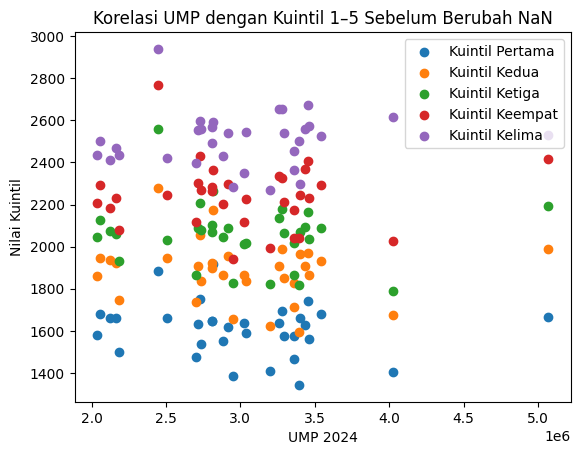

In [94]:
import matplotlib.pyplot as plt

for col in ['Kuintil Pertama','Kuintil Kedua','Kuintil Ketiga','Kuintil Keempat','Kuintil Kelima']:
    plt.scatter(df_gabungan['UMP_2024'], df_gabungan[col], label=col)

plt.xlabel('UMP 2024')
plt.ylabel('Nilai Kuintil')
plt.title('Korelasi UMP dengan Kuintil 1–5 Sebelum Berubah NaN')
plt.legend()
plt.show()


In [95]:
#ISI NAN PAPUA PEMEKARAN DENGAN NILAI PAPUA
kolom = ['Kuintil Pertama', 'Kuintil Kedua', 'Kuintil Ketiga', 'Kuintil Keempat', 'Kuintil Kelima']
baris = df_gabungan['Provinsi'].isin(['Papua Pegunungan', 'Papua Barat Daya', 'Papua Selatan', 'Papua Tengah'])

df_gabungan.loc[baris, kolom] = [1402.98, 1674.22, 1790.51, 2028.20, 2617.53]

df_gabungan.loc[baris, ['Provinsi'] + kolom]


,Provinsi,Kuintil Pertama,Kuintil Kedua,Kuintil Ketiga,Kuintil Keempat,Kuintil Kelima
25,Papua Barat Daya,1402.98,1674.22,1790.51,2028.2,2617.53
26,Papua Pegunungan,1402.98,1674.22,1790.51,2028.2,2617.53
27,Papua Selatan,1402.98,1674.22,1790.51,2028.2,2617.53
28,Papua Tengah,1402.98,1674.22,1790.51,2028.2,2617.53


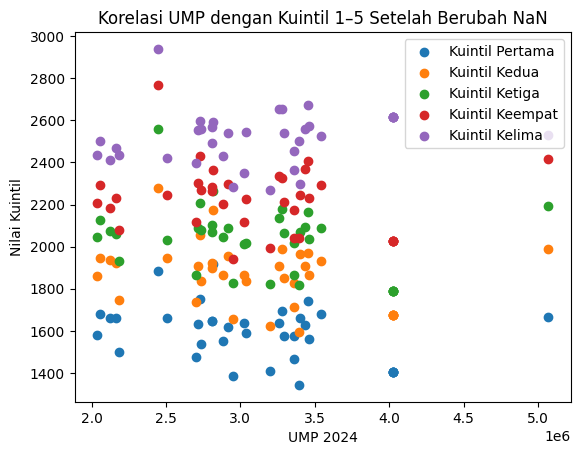

In [96]:
import matplotlib.pyplot as plt

for col in ['Kuintil Pertama','Kuintil Kedua','Kuintil Ketiga','Kuintil Keempat','Kuintil Kelima']:
    plt.scatter(df_gabungan['UMP_2024'], df_gabungan[col], label=col)

plt.xlabel('UMP 2024')
plt.ylabel('Nilai Kuintil')
plt.title('Korelasi UMP dengan Kuintil 1–5 Setelah Berubah NaN')
plt.legend()
plt.show()


### 2.3. Mengatasi nilai NaN kolom stunting dengan metode isi nilai NaN dengan median

In [97]:
df_gabungan.isna().sum()

Provinsi                            0
UMP_2024                            0
Kuintil Pertama                     0
Kuintil Kedua                       0
Kuintil Ketiga                      0
Kuintil Keempat                     0
Kuintil Kelima                      0
Stunting                           13
Wasting                            13
Kelebihan berat badan              13
Kelebihan BB Anak 5-12 tahun        0
Kelebihan BB Remaja 13-15 tahun     0
Kelebihan BB Remaja 16-18 tahun     0
Kelebihan BB Dewasa >18 tahun       7
Kerawanan pangan                   17
dtype: int64

In [98]:
df_gabungan["Stunting"].describe()


count    24.000000
mean     24.795833
std       6.026787
min      14.900000
25%      21.050000
50%      24.600000
75%      27.700000
max      39.300000
Name: Stunting, dtype: float64

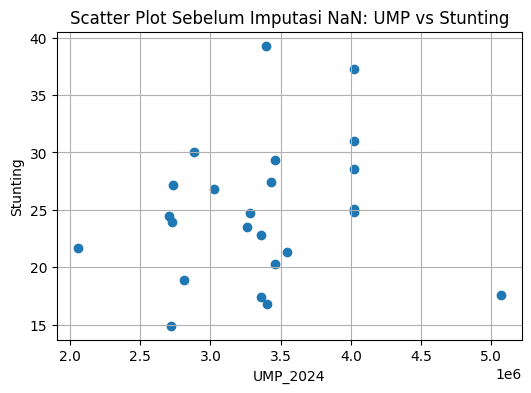

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.scatter(df_gabungan["UMP_2024"], df_gabungan["Stunting"])
plt.title("Scatter Plot Sebelum Imputasi NaN: UMP vs Stunting")
plt.xlabel("UMP_2024")
plt.ylabel("Stunting")
plt.grid(True)
plt.show()


In [100]:
median_stunting = df_gabungan["Stunting"].median()

df_gabungan["Stunting"] = df_gabungan["Stunting"].fillna(median_stunting)


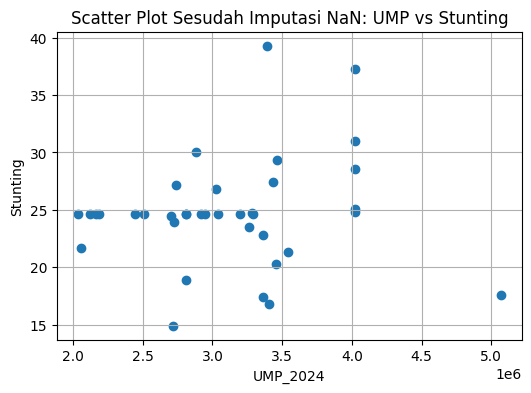

In [101]:
plt.figure(figsize=(6,4))
plt.scatter(df_gabungan["UMP_2024"], df_gabungan["Stunting"])
plt.title("Scatter Plot Sesudah Imputasi NaN: UMP vs Stunting")
plt.xlabel("UMP_2024")
plt.ylabel("Stunting")
plt.grid(True)
plt.show()


### 2.4. Mengatasi nilai NaN kolom Wasting dengan metode isi nilai NaN dengan median

In [102]:
df_gabungan[df_gabungan["Wasting"].isna()]


,Provinsi,UMP_2024,Kuintil Pertama,Kuintil Kedua,Kuintil Ketiga,Kuintil Keempat,Kuintil Kelima,Stunting,Wasting,Kelebihan berat badan,Kelebihan BB Anak 5-12 tahun,Kelebihan BB Remaja 13-15 tahun,Kelebihan BB Remaja 16-18 tahun,Kelebihan BB Dewasa >18 tahun,Kerawanan pangan
1,Bali,2813672,1918.83,2175.64,2266.56,2366.14,2590.63,24.6,NaN,NaN,26.7,20.0,13.2,39.8,NaN
4,Bengkulu,2507079,1661.21,1943.68,2030.50,2243.65,2420.84,24.6,NaN,NaN,23.6,15.2,7.7,NaN,NaN
5,D.I. Yogyakarta,2125897,1661.76,1935.91,2072.51,2181.61,2412.39,24.6,NaN,NaN,21.6,25.6,19.1,39.0,NaN
8,Jambi,3037121,1588.60,1837.40,2018.34,2225.61,2543.68,24.6,NaN,NaN,19.2,10.5,5.2,NaN,NaN
10,Jawa Tengah,2036947,1579.14,1860.01,2043.44,2207.25,2434.89,24.6,NaN,NaN,21.3,15.2,11.6,36.0,NaN
11,Jawa Timur,2165244,1660.82,1922.42,2061.40,2230.83,2466.43,24.6,NaN,NaN,23.5,19.8,14.9,38.2,NaN
19,Maluku,2949953,1387.53,1654.20,1829.46,1943.43,2283.78,24.6,NaN,NaN,9.9,8.5,4.9,NaN,NaN
20,Maluku Utara,3200000,1408.92,1623.74,1820.27,1992.56,2269.37,24.6,NaN,NaN,16.3,13.2,9.8,37.6,NaN
21,Nusa Tenggara Barat,2444067,1883.94,2276.32,2557.66,2767.94,2938.93,24.6,NaN,NaN,12.9,10.4,8.5,NaN,NaN
22,Nusa Tenggara Timur,2186826,1497.89,1747.09,1931.61,2078.62,2435.64,24.6,NaN,NaN,6.1,4.5,4.7,NaN,NaN


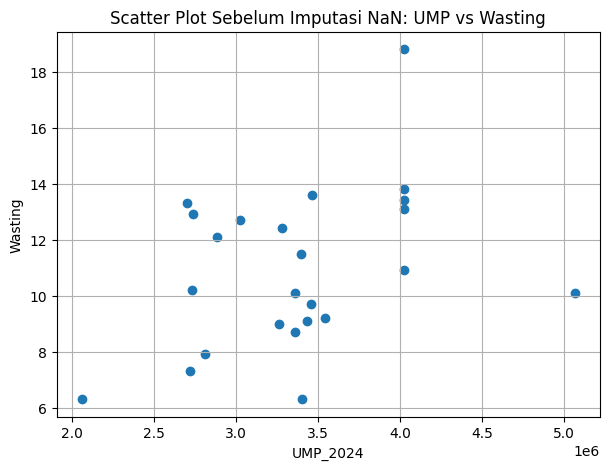

In [103]:
plt.figure(figsize=(7,5))
plt.scatter(df_gabungan["UMP_2024"], df_gabungan["Wasting"])
plt.xlabel("UMP_2024")
plt.ylabel("Wasting")
plt.title("Scatter Plot Sebelum Imputasi NaN: UMP vs Wasting")
plt.grid(True)
plt.show()


In [104]:
median_wasting = df_gabungan["Wasting"].median()
df_gabungan["Wasting"] = df_gabungan["Wasting"].fillna(median_wasting)


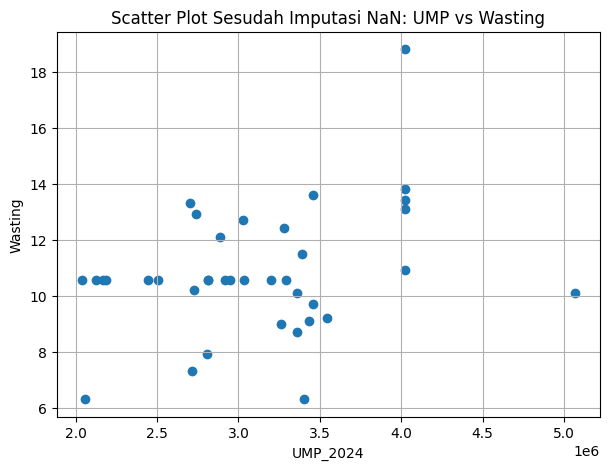

In [105]:
plt.figure(figsize=(7,5))
plt.scatter(df_gabungan["UMP_2024"], df_gabungan["Wasting"])
plt.xlabel("UMP_2024")
plt.ylabel("Wasting")
plt.title("Scatter Plot Sesudah Imputasi NaN: UMP vs Wasting")
plt.grid(True)
plt.show()


### 2.5. Mengatasi nilai NaN kolom prevelensi kelebihan berat badan dengan metode isi nilai NaN dengan median

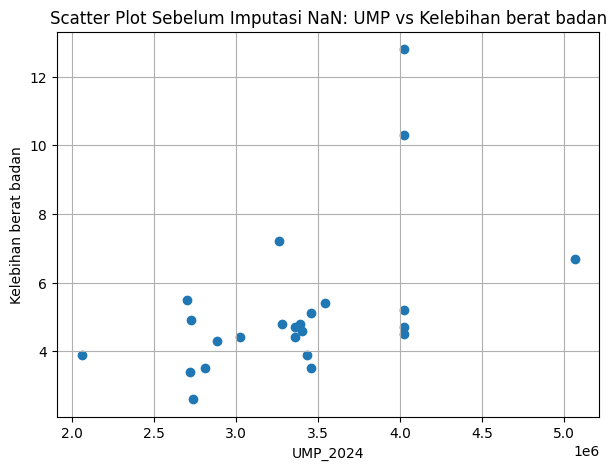

In [106]:
plt.figure(figsize=(7,5))
plt.scatter(df_gabungan["UMP_2024"], df_gabungan["Kelebihan berat badan"])
plt.xlabel("UMP_2024")
plt.ylabel("Kelebihan berat badan")
plt.title("Scatter Plot Sebelum Imputasi NaN: UMP vs Kelebihan berat badan")
plt.grid(True)
plt.show()

In [107]:
median_wasting = df_gabungan["Kelebihan berat badan"].median()
df_gabungan["Kelebihan berat badan"] = df_gabungan["Kelebihan berat badan"].fillna(median_wasting)


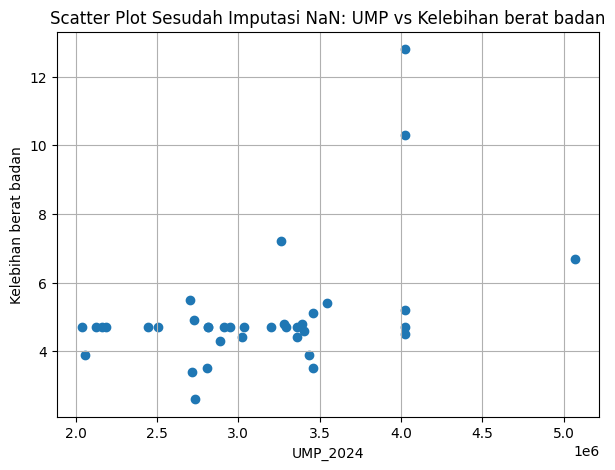

In [108]:
plt.figure(figsize=(7,5))
plt.scatter(df_gabungan["UMP_2024"], df_gabungan["Kelebihan berat badan"])
plt.xlabel("UMP_2024")
plt.ylabel("Kelebihan berat badan")
plt.title("Scatter Plot Sesudah Imputasi NaN: UMP vs Kelebihan berat badan")
plt.grid(True)
plt.show()


### 2.6. Menangani NaN kolom kelebihan bb dewasa >18 tahun dengan metode megganti dengan nilai median

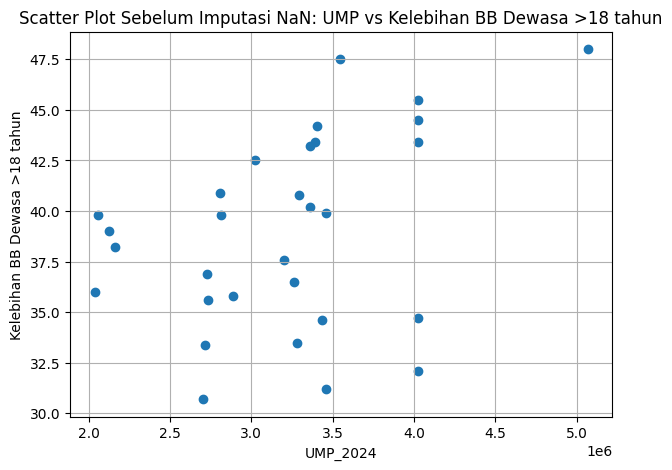

In [109]:
plt.figure(figsize=(7,5))
plt.scatter(df_gabungan["UMP_2024"], df_gabungan["Kelebihan BB Dewasa >18 tahun"])
plt.xlabel("UMP_2024")
plt.ylabel("Kelebihan BB Dewasa >18 tahun")
plt.title("Scatter Plot Sebelum Imputasi NaN: UMP vs Kelebihan BB Dewasa >18 tahun")
plt.grid(True)
plt.show()

In [110]:
median_wasting = df_gabungan["Kelebihan BB Dewasa >18 tahun"].median()
df_gabungan["Kelebihan BB Dewasa >18 tahun"] = df_gabungan["Kelebihan BB Dewasa >18 tahun"].fillna(median_wasting)


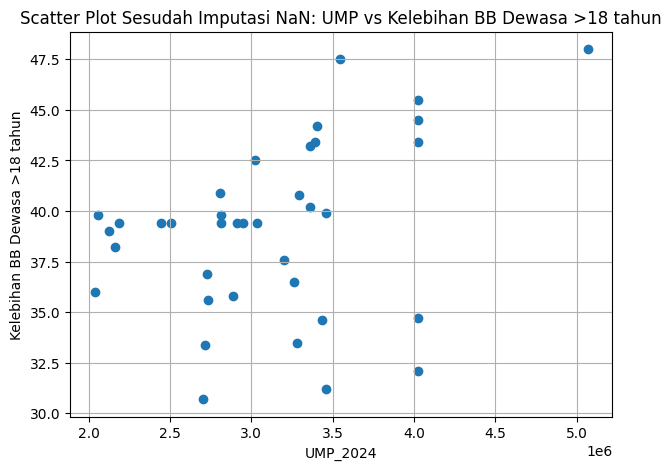

In [111]:
plt.figure(figsize=(7,5))
plt.scatter(df_gabungan["UMP_2024"], df_gabungan["Kelebihan BB Dewasa >18 tahun"])
plt.xlabel("UMP_2024")
plt.ylabel("Kelebihan BB Dewasa >18 tahun")
plt.title("Scatter Plot Sesudah Imputasi NaN: UMP vs Kelebihan BB Dewasa >18 tahun")
plt.grid(True)
plt.show()

### 2.7. Menangani NaN kolom prevelensi kerawanan pangan dengan metode mengganti nilai NaN dengan nilai median dan untuk provinsi pemerkaran Papua menggati nilai sesuai dengan nilai Papua Pusat

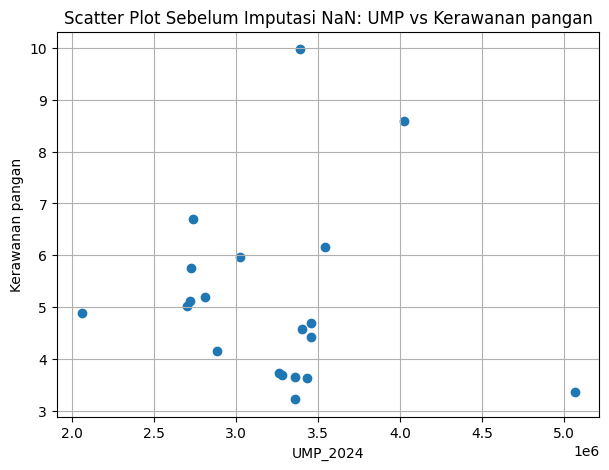

In [112]:
plt.figure(figsize=(7,5))
plt.scatter(df_gabungan["UMP_2024"], df_gabungan["Kerawanan pangan"])
plt.xlabel("UMP_2024")
plt.ylabel("Kerawanan pangan")
plt.title("Scatter Plot Sebelum Imputasi NaN: UMP vs Kerawanan pangan")
plt.grid(True)
plt.show()

In [113]:
#UNTUK PROVINSI PEMEKARAN PAPUA
provinsi_pemekaran_papua = [
    'Papua Pegunungan', 'Papua Barat Daya',
    'Papua Selatan', 'Papua Tengah']

filter_papua = df_gabungan['Provinsi'].isin(provinsi_pemekaran_papua)
filter_non_papua = df_gabungan['Provinsi'].isin(provinsi_pemekaran_papua) == False


# Untuk provinsi pemekaran Papua → samakan dengan Papua induk
nilai_papua_induk = df_gabungan.loc[df_gabungan['Provinsi'] == 'Papua', 'Kerawanan pangan'].values[0]
df_gabungan.loc[filter_papua, 'Kerawanan pangan'] = nilai_papua_induk

# Untuk provinsi lain, isi dengan median nasional
median_nasional = df_gabungan.loc[filter_non_papua, 'Kerawanan pangan'].median()
df_gabungan.loc[df_gabungan['Kerawanan pangan'].isna() & filter_non_papua, 'Kerawanan pangan'] = median_nasional



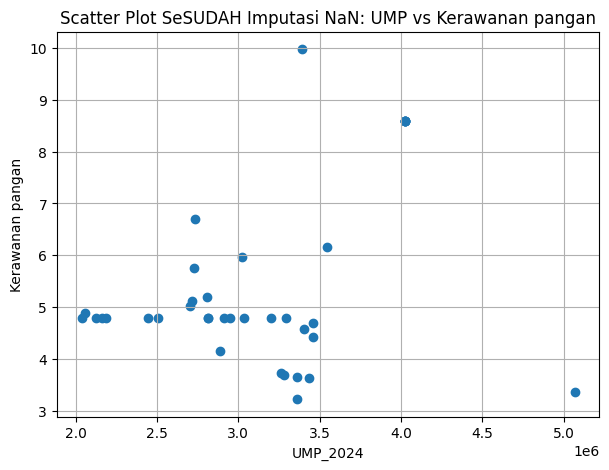

In [114]:
plt.figure(figsize=(7,5))
plt.scatter(df_gabungan["UMP_2024"], df_gabungan["Kerawanan pangan"])
plt.xlabel("UMP_2024")
plt.ylabel("Kerawanan pangan")
plt.title("Scatter Plot SeSUDAH Imputasi NaN: UMP vs Kerawanan pangan")
plt.grid(True)
plt.show()

In [115]:
df_gabungan.isna().sum()

Provinsi                           0
UMP_2024                           0
Kuintil Pertama                    0
Kuintil Kedua                      0
Kuintil Ketiga                     0
Kuintil Keempat                    0
Kuintil Kelima                     0
Stunting                           0
Wasting                            0
Kelebihan berat badan              0
Kelebihan BB Anak 5-12 tahun       0
Kelebihan BB Remaja 13-15 tahun    0
Kelebihan BB Remaja 16-18 tahun    0
Kelebihan BB Dewasa >18 tahun      0
Kerawanan pangan                   0
dtype: int64

In [116]:
df_gabungan = df_gabungan.reset_index(drop=True)
df_gabungan.head(38)

,Provinsi,UMP_2024,Kuintil Pertama,Kuintil Kedua,Kuintil Ketiga,Kuintil Keempat,Kuintil Kelima,Stunting,Wasting,Kelebihan berat badan,Kelebihan BB Anak 5-12 tahun,Kelebihan BB Remaja 13-15 tahun,Kelebihan BB Remaja 16-18 tahun,Kelebihan BB Dewasa >18 tahun,Kerawanan pangan
0,Aceh,3460672,1559.07,1863.50,2038.54,2228.84,2574.43,29.3,13.60,3.5,17.2,15.3,12.1,39.9,4.70
1,Bali,2813672,1918.83,2175.64,2266.56,2366.14,2590.63,24.6,10.55,4.7,26.7,20.0,13.2,39.8,4.80
2,Banten,2727812,1752.49,2053.64,2205.32,2428.25,2597.54,23.9,10.20,4.9,19.3,15.6,10.5,36.9,5.76
3,Bengkulu,2507079,1661.21,1943.68,2030.50,2243.65,2420.84,24.6,10.55,4.7,23.6,15.2,7.7,39.4,4.80
4,D.I. Yogyakarta,2125897,1661.76,1935.91,2072.51,2181.61,2412.39,24.6,10.55,4.7,21.6,25.6,19.1,39.0,4.80
5,DKI Jakarta,5067381,1665.07,1987.44,2191.06,2417.09,2528.61,17.6,10.10,6.7,27.3,23.3,19.2,48.0,3.36
6,Gorontalo,3025100,1635.97,1864.76,2014.22,2118.37,2347.49,26.8,12.70,4.4,17.0,14.3,14.8,42.5,5.96
7,Jambi,3037121,1588.60,1837.40,2018.34,2225.61,2543.68,24.6,10.55,4.7,19.2,10.5,5.2,39.4,4.80
8,Jawa Barat,2057495,1682.32,1947.48,2128.39,2293.57,2499.94,21.7,6.30,3.9,18.4,17.0,13.1,39.8,4.90
9,Jawa Tengah,2036947,1579.14,1860.01,2043.44,2207.25,2434.89,24.6,10.55,4.7,21.3,15.2,11.6,36.0,4.80


# C. Data Eksplorasi


## 1. Menangani Outlier

In [117]:
print(df_gabungan.columns.tolist())

['Provinsi', 'UMP_2024', 'Kuintil Pertama', 'Kuintil Kedua', 'Kuintil Ketiga', 'Kuintil Keempat', 'Kuintil Kelima', 'Stunting', 'Wasting', 'Kelebihan berat badan', 'Kelebihan BB Anak 5-12 tahun', 'Kelebihan BB Remaja 13-15 tahun', 'Kelebihan BB Remaja 16-18 tahun', 'Kelebihan BB Dewasa >18 tahun', 'Kerawanan pangan']


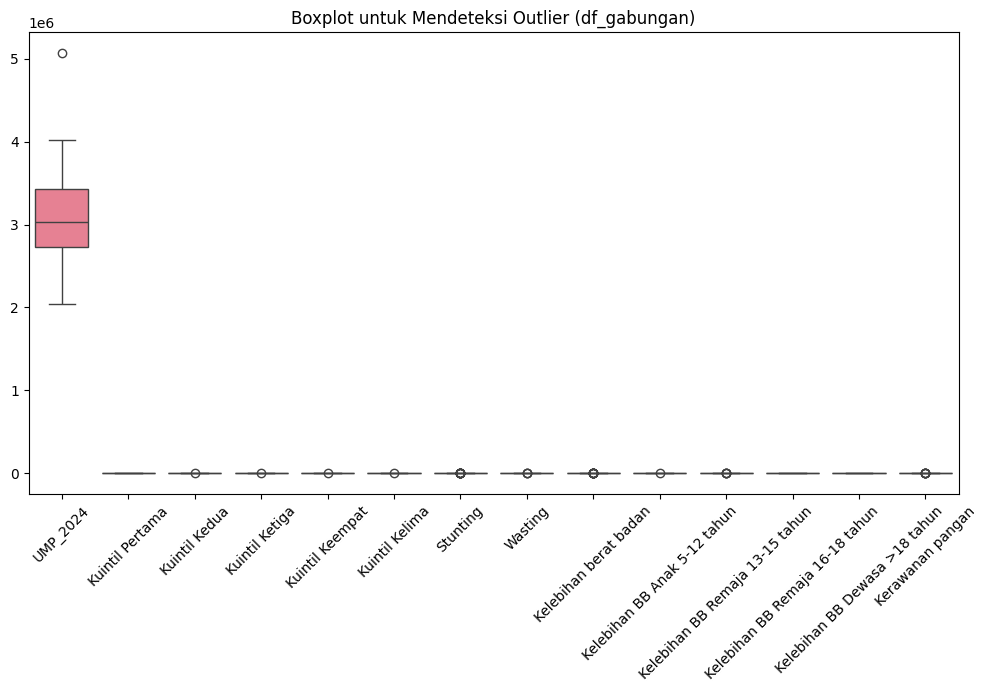

=== BATAS IQR TIAP KOLOM ===
Lower bound:
 UMP_2024                           1668083.000
Kuintil Pertama                       1199.935
Kuintil Kedua                         1430.280
Kuintil Ketiga                        1531.515
Kuintil Keempat                       1750.495
Kuintil Kelima                        2190.915
Stunting                                21.100
Wasting                                  7.100
Kelebihan berat badan                    4.050
Kelebihan BB Anak 5-12 tahun             7.600
Kelebihan BB Remaja 13-15 tahun          8.100
Kelebihan BB Remaja 16-18 tahun          2.450
Kelebihan BB Dewasa >18 tahun           28.650
Kerawanan pangan                         3.110
dtype: float64
Upper bound:
 UMP_2024                           4494027.000
Kuintil Pertama                       1937.975
Kuintil Kedua                         2251.720
Kuintil Ketiga                        2426.755
Kuintil Keempat                       2625.495
Kuintil Kelima                     

,Provinsi,UMP_2024,Kuintil Pertama,Kuintil Kedua,Kuintil Ketiga,Kuintil Keempat,Kuintil Kelima,Stunting,Wasting,Kelebihan berat badan,Kelebihan BB Anak 5-12 tahun,Kelebihan BB Remaja 13-15 tahun,Kelebihan BB Remaja 16-18 tahun,Kelebihan BB Dewasa >18 tahun,Kerawanan pangan
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.3,NaN,3.5,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.6,NaN,NaN,NaN
5,NaN,5067381.0,NaN,NaN,NaN,NaN,NaN,17.6,NaN,6.7,NaN,23.3,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.3,3.9,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.5,NaN,NaN,NaN,NaN,NaN
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.2,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.8,6.3,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.9,NaN,3.4,NaN,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,2276.32,2557.66,2767.94,2938.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Kolom numeric untuk deteksi outlier
numeric_cols = ['UMP_2024','Kuintil Pertama','Kuintil Kedua','Kuintil Ketiga',
                'Kuintil Keempat','Kuintil Kelima','Stunting','Wasting',
                'Kelebihan berat badan','Kelebihan BB Anak 5-12 tahun',
                'Kelebihan BB Remaja 13-15 tahun','Kelebihan BB Remaja 16-18 tahun',
                'Kelebihan BB Dewasa >18 tahun','Kerawanan pangan']

# Visualisasi boxplot semua kolom numeric
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_gabungan[numeric_cols])
plt.title("Boxplot untuk Mendeteksi Outlier (df_gabungan)")
plt.xticks(rotation=45)
plt.show()

# Hitung IQR tiap kolom numeric
Q1 = df_gabungan[numeric_cols].quantile(0.25)
Q3 = df_gabungan[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("=== BATAS IQR TIAP KOLOM ===")
print("Lower bound:\n", lower_bound)
print("Upper bound:\n", upper_bound)

# Menampilkan baris yang mengandung outlier
outliers = df_gabungan[(df_gabungan[numeric_cols] < lower_bound) |
                       (df_gabungan[numeric_cols] > upper_bound)].dropna(how='all')

print("\n=== DATA YANG TERDETEKSI SEBAGAI OUTLIER ===")
display(outliers[['Provinsi'] + numeric_cols])


In [119]:
# Hitung jumlah outlier per baris
outlier_flags = (df_gabungan[numeric_cols] < lower_bound) | (df_gabungan[numeric_cols] > upper_bound)
df_gabungan['outlier_count'] = outlier_flags.sum(axis=1)

# Cek berapa baris yang outlier_count > 3
print(df_gabungan[df_gabungan['outlier_count'] > 3])


               Provinsi  UMP_2024  Kuintil Pertama  Kuintil Kedua  \
5           DKI Jakarta   5067381          1665.07        1987.44   
20  Nusa Tenggara Barat   2444067          1883.94        2276.32   
27         Papua Tengah   4024270          1402.98        1674.22   

    Kuintil Ketiga  Kuintil Keempat  Kuintil Kelima  Stunting  Wasting  \
5          2191.06          2417.09         2528.61      17.6    10.10   
20         2557.66          2767.94         2938.93      24.6    10.55   
27         1790.51          2028.20         2617.53      28.6    18.80   

    Kelebihan berat badan  Kelebihan BB Anak 5-12 tahun  \
5                     6.7                          27.3   
20                    4.7                          12.9   
27                   12.8                          28.7   

    Kelebihan BB Remaja 13-15 tahun  Kelebihan BB Remaja 16-18 tahun  \
5                              23.3                             19.2   
20                             10.4          

Untuk menangani outlier menggunakan metode menghapus baris, jika dalam satu baris terdapat nilai outlier lebih dari 3. Untuk baris yang nilai outlier hanya 1 dan 2 maka mengganti nilai menjadi nilai median

In [120]:
df_clean = df_gabungan[df_gabungan['outlier_count'] <= 3].copy()
print(f"Jumlah baris setelah penghapusan (>3 outlier): {len(df_clean)}")
print("-" * 50)


# Ganti Outlier Sisanya dengan Median (Menggunakan Batas BARU)
for col in numeric_cols:
    Q1_new = df_clean[col].quantile(0.25)
    Q3_new = df_clean[col].quantile(0.75)
    IQR_new = Q3_new - Q1_new

    lower_new = Q1_new - 1.5 * IQR_new
    upper_new = Q3_new + 1.5 * IQR_new
    median_new = df_clean[col].median()

    outliers_mask = (df_clean[col] < lower_new) | (df_clean[col] > upper_new)

    count_replaced = outliers_mask.sum()
    if count_replaced > 0:
        df_clean.loc[outliers_mask, col] = median_new
        print(f"Kolom '{col}': {count_replaced} nilai outlier diganti dengan median ({median_new:,.2f})")

print("-" * 50)

df_clean = df_clean.drop(columns='outlier_count')

print("✅ Penanganan Outlier Selesai.")

Jumlah baris setelah penghapusan (>3 outlier): 34
--------------------------------------------------
Kolom 'Stunting': 13 nilai outlier diganti dengan median (24.60)
Kolom 'Wasting': 2 nilai outlier diganti dengan median (10.55)
Kolom 'Kelebihan berat badan': 10 nilai outlier diganti dengan median (4.70)
Kolom 'Kelebihan BB Anak 5-12 tahun': 1 nilai outlier diganti dengan median (18.80)
Kolom 'Kelebihan BB Remaja 13-15 tahun': 5 nilai outlier diganti dengan median (15.25)
Kolom 'Kelebihan BB Remaja 16-18 tahun': 1 nilai outlier diganti dengan median (11.10)
Kolom 'Kerawanan pangan': 6 nilai outlier diganti dengan median (4.80)
--------------------------------------------------
✅ Penanganan Outlier Selesai.


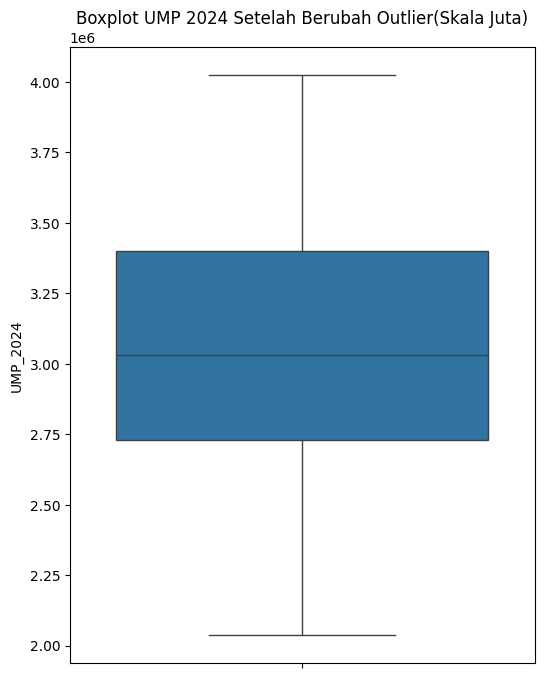

In [121]:
plt.figure(figsize=(6, 8))
sns.boxplot(y=df_clean['UMP_2024'])
plt.title('Boxplot UMP 2024 Setelah Berubah Outlier(Skala Juta)')
plt.show()

Keterangan boxplot: berdasarkan boxplot, kolom UMP sudah tidak memiliki nilai Outlier

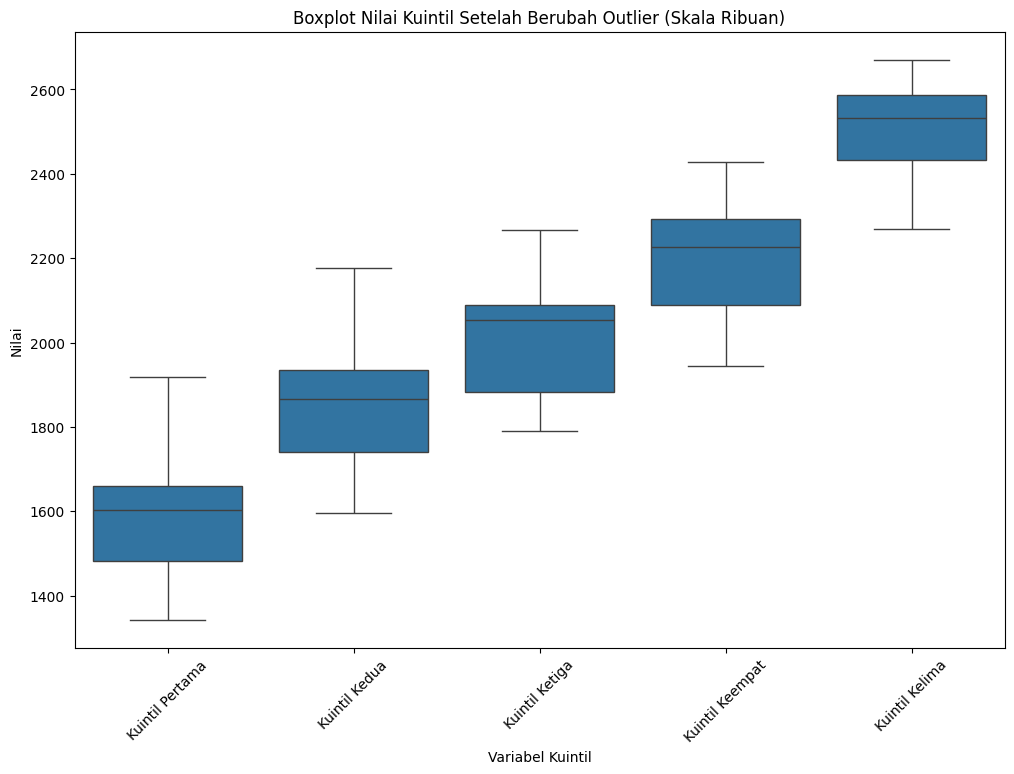

In [122]:
plt.figure(figsize=(12, 8))
# Pilih kolom Kuintil
kuintil_cols = ['Kuintil Pertama', 'Kuintil Kedua', 'Kuintil Ketiga', 'Kuintil Keempat', 'Kuintil Kelima']

# Gunakan melt untuk membuat data cocok untuk boxplot
df_kuintil = df_clean[kuintil_cols].melt()

sns.boxplot(x='variable', y='value', data=df_kuintil)
plt.title('Boxplot Nilai Kuintil Setelah Berubah Outlier (Skala Ribuan)')
plt.xlabel('Variabel Kuintil')
plt.ylabel('Nilai')
plt.xticks(rotation=45)
plt.show()

Keterangan boxplot: berdasarkan boxplot, kolom Kuintil sudah tidak memiliki nilai Outlier

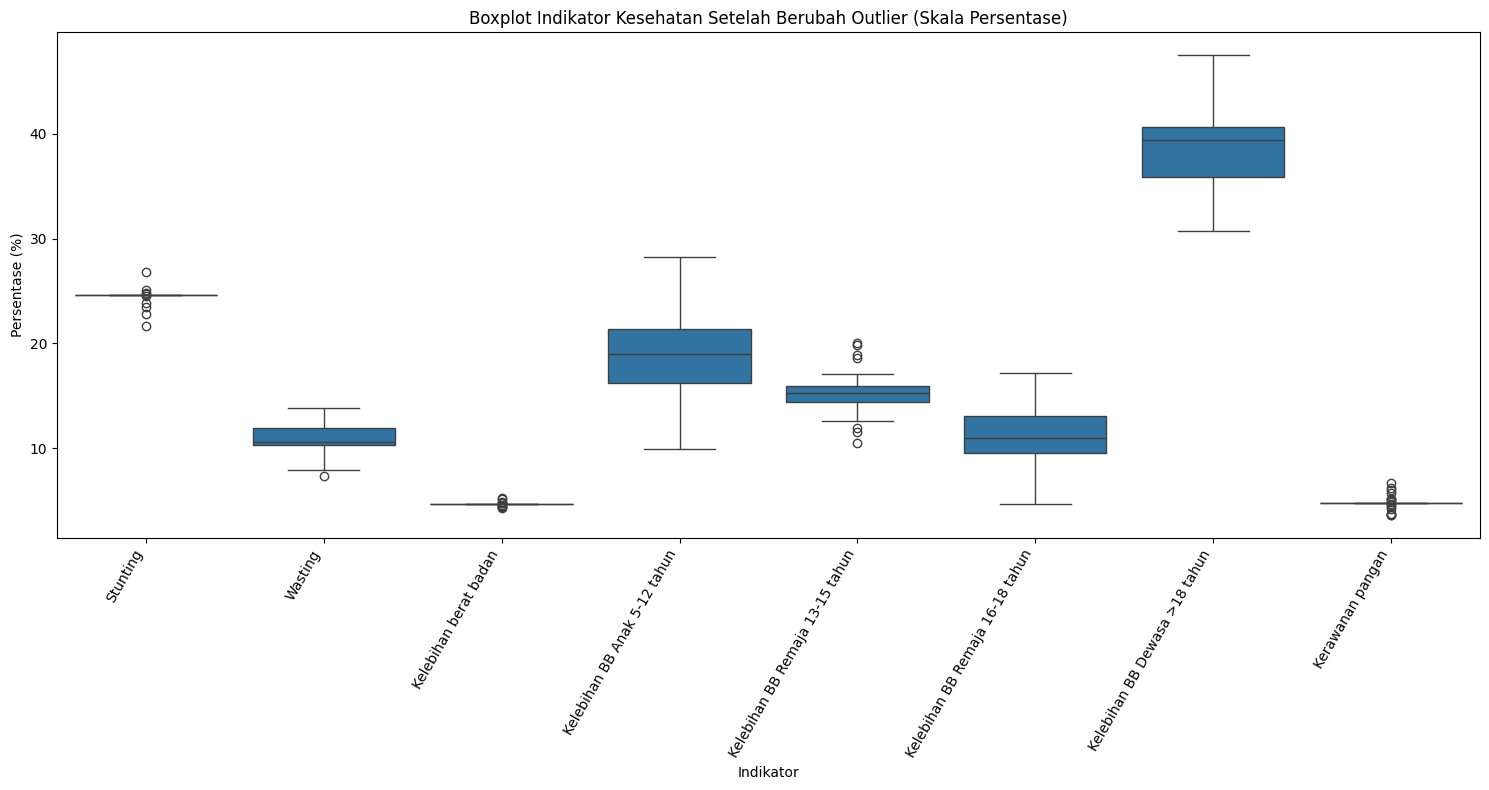

In [123]:
plt.figure(figsize=(15, 8))
# Pilih kolom Indikator Kesehatan
kesehatan_cols = ['Stunting', 'Wasting', 'Kelebihan berat badan', 'Kelebihan BB Anak 5-12 tahun',
                  'Kelebihan BB Remaja 13-15 tahun', 'Kelebihan BB Remaja 16-18 tahun',
                  'Kelebihan BB Dewasa >18 tahun', 'Kerawanan pangan']

# Gunakan melt untuk membuat data cocok untuk boxplot
df_Kesehatan = df_clean[kesehatan_cols].melt()

sns.boxplot(x='variable', y='value', data=df_Kesehatan)
plt.title('Boxplot Indikator Kesehatan Setelah Berubah Outlier (Skala Persentase)')
plt.xlabel('Indikator')
plt.ylabel('Persentase (%)')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

Keterangan boxplot: berdasarkan boxplot, kolom-kolom data kesehtan, sudah beberapa kolom tidak memiliki nilai Outlier. Kolom yang masih memliki outlier itu merupakan hasil dari perubahan dengan nilai median


In [124]:
df_check = df_clean.copy()

numeric_cols = ['UMP_2024','Kuintil Pertama','Kuintil Kedua','Kuintil Ketiga',
                'Kuintil Keempat','Kuintil Kelima','Stunting','Wasting',
                'Kelebihan berat badan','Kelebihan BB Anak 5-12 tahun',
                'Kelebihan BB Remaja 13-15 tahun','Kelebihan BB Remaja 16-18 tahun',
                'Kelebihan BB Dewasa >18 tahun','Kerawanan pangan']

# Hitung IQR per kolom
Q1 = df_check[numeric_cols].quantile(0.25)
Q3 = df_check[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

# Tandai outlier
for col in numeric_cols:
    df_check[col+'_outlier'] = df_check[col].apply(
        lambda x: 'Noise' if (x < 0 or pd.isna(x)) else
                  ('Sah_Outlier' if (x < lower_bound[col] or x > upper_bound[col]) else 'Normal')
    )

# Contoh cek
df_check[['Provinsi','Stunting','Stunting_outlier']].head(10)


,Provinsi,Stunting,Stunting_outlier
0,Aceh,24.6,Normal
1,Bali,24.6,Normal
2,Banten,23.9,Sah_Outlier
3,Bengkulu,24.6,Normal
4,D.I. Yogyakarta,24.6,Normal
6,Gorontalo,26.8,Sah_Outlier
7,Jambi,24.6,Normal
8,Jawa Barat,21.7,Sah_Outlier
9,Jawa Tengah,24.6,Normal
10,Jawa Timur,24.6,Normal


In [125]:
df_clean.head(38)

,Provinsi,UMP_2024,Kuintil Pertama,Kuintil Kedua,Kuintil Ketiga,Kuintil Keempat,Kuintil Kelima,Stunting,Wasting,Kelebihan berat badan,Kelebihan BB Anak 5-12 tahun,Kelebihan BB Remaja 13-15 tahun,Kelebihan BB Remaja 16-18 tahun,Kelebihan BB Dewasa >18 tahun,Kerawanan pangan
0,Aceh,3460672,1559.07,1863.50,2038.54,2228.84,2574.43,24.6,13.60,4.7,17.2,15.30,12.1,39.9,4.70
1,Bali,2813672,1918.83,2175.64,2266.56,2366.14,2590.63,24.6,10.55,4.7,26.7,20.00,13.2,39.8,4.80
2,Banten,2727812,1752.49,2053.64,2205.32,2428.25,2597.54,23.9,10.20,4.9,19.3,15.60,10.5,36.9,5.76
3,Bengkulu,2507079,1661.21,1943.68,2030.50,2243.65,2420.84,24.6,10.55,4.7,23.6,15.20,7.7,39.4,4.80
4,D.I. Yogyakarta,2125897,1661.76,1935.91,2072.51,2181.61,2412.39,24.6,10.55,4.7,21.6,15.25,11.1,39.0,4.80
6,Gorontalo,3025100,1635.97,1864.76,2014.22,2118.37,2347.49,26.8,12.70,4.4,17.0,14.30,14.8,42.5,5.96
7,Jambi,3037121,1588.60,1837.40,2018.34,2225.61,2543.68,24.6,10.55,4.7,19.2,10.50,5.2,39.4,4.80
8,Jawa Barat,2057495,1682.32,1947.48,2128.39,2293.57,2499.94,21.7,10.55,4.7,18.4,17.00,13.1,39.8,4.90
9,Jawa Tengah,2036947,1579.14,1860.01,2043.44,2207.25,2434.89,24.6,10.55,4.7,21.3,15.20,11.6,36.0,4.80
10,Jawa Timur,2165244,1660.82,1922.42,2061.40,2230.83,2466.43,24.6,10.55,4.7,23.5,19.80,14.9,38.2,4.80


In [126]:
df_clean.info()
df_clean.isna().sum()


<class 'pandas.core.frame.DataFrame'>
Index: 34 entries, 0 to 36
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Provinsi                         34 non-null     object 
 1   UMP_2024                         34 non-null     int64  
 2   Kuintil Pertama                  34 non-null     float64
 3   Kuintil Kedua                    34 non-null     float64
 4   Kuintil Ketiga                   34 non-null     float64
 5   Kuintil Keempat                  34 non-null     float64
 6   Kuintil Kelima                   34 non-null     float64
 7   Stunting                         34 non-null     float64
 8   Wasting                          34 non-null     float64
 9   Kelebihan berat badan            34 non-null     float64
 10  Kelebihan BB Anak 5-12 tahun     34 non-null     float64
 11  Kelebihan BB Remaja 13-15 tahun  34 non-null     float64
 12  Kelebihan BB Remaja 16-18 tah

Provinsi                           0
UMP_2024                           0
Kuintil Pertama                    0
Kuintil Kedua                      0
Kuintil Ketiga                     0
Kuintil Keempat                    0
Kuintil Kelima                     0
Stunting                           0
Wasting                            0
Kelebihan berat badan              0
Kelebihan BB Anak 5-12 tahun       0
Kelebihan BB Remaja 13-15 tahun    0
Kelebihan BB Remaja 16-18 tahun    0
Kelebihan BB Dewasa >18 tahun      0
Kerawanan pangan                   0
dtype: int64

## 2. Statistika Deskriptif Untuk Dataset

In [127]:
#!.Descriptive statistics
df_clean.describe()

,UMP_2024,Kuintil Pertama,Kuintil Kedua,Kuintil Ketiga,Kuintil Keempat,Kuintil Kelima,Stunting,Wasting,Kelebihan berat badan,Kelebihan BB Anak 5-12 tahun,Kelebihan BB Remaja 13-15 tahun,Kelebihan BB Remaja 16-18 tahun,Kelebihan BB Dewasa >18 tahun,Kerawanan pangan
count,3.400000e+01,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,3.051832e+06,1579.717353,1850.395882,2013.317059,2200.867059,2503.226471,24.494118,10.841176,4.700000,19.047059,15.242647,11.138235,38.626471,4.817353
std,5.637724e+05,127.255918,132.637101,133.679480,128.979863,109.793343,0.740983,1.600638,0.161433,3.908285,2.120111,3.142284,4.036223,0.646099
min,2.036947e+06,1343.240000,1596.200000,1790.510000,1943.430000,2269.370000,21.700000,7.300000,4.300000,9.900000,10.500000,4.700000,30.700000,3.630000
25%,2.730034e+06,1481.997500,1740.512500,1883.325000,2088.557500,2432.857500,24.600000,10.287500,4.700000,16.225000,14.400000,9.525000,35.850000,4.800000
50%,3.031110e+06,1602.440000,1865.805000,2053.260000,2227.225000,2532.610000,24.600000,10.550000,4.700000,19.000000,15.250000,10.950000,39.400000,4.800000
75%,3.400119e+06,1660.780000,1935.017500,2089.130000,2293.542500,2586.580000,24.600000,11.950000,4.700000,21.400000,15.950000,13.050000,40.650000,4.800000
max,4.024270e+06,1918.830000,2175.640000,2266.560000,2428.250000,2670.340000,26.800000,13.800000,5.200000,28.200000,20.000000,17.200000,47.500000,6.710000


In [128]:
df_eda = df_clean.copy()

# Kolom numerik
numeric_cols = ['UMP_2024','Kuintil Pertama','Kuintil Kedua','Kuintil Ketiga',
                'Kuintil Keempat','Kuintil Kelima','Stunting','Wasting',
                'Kelebihan berat badan','Kelebihan BB Anak 5-12 tahun',
                'Kelebihan BB Remaja 13-15 tahun','Kelebihan BB Remaja 16-18 tahun',
                'Kelebihan BB Dewasa >18 tahun','Kerawanan pangan']


## 3. Distibusi Untuk Tiap Kolom

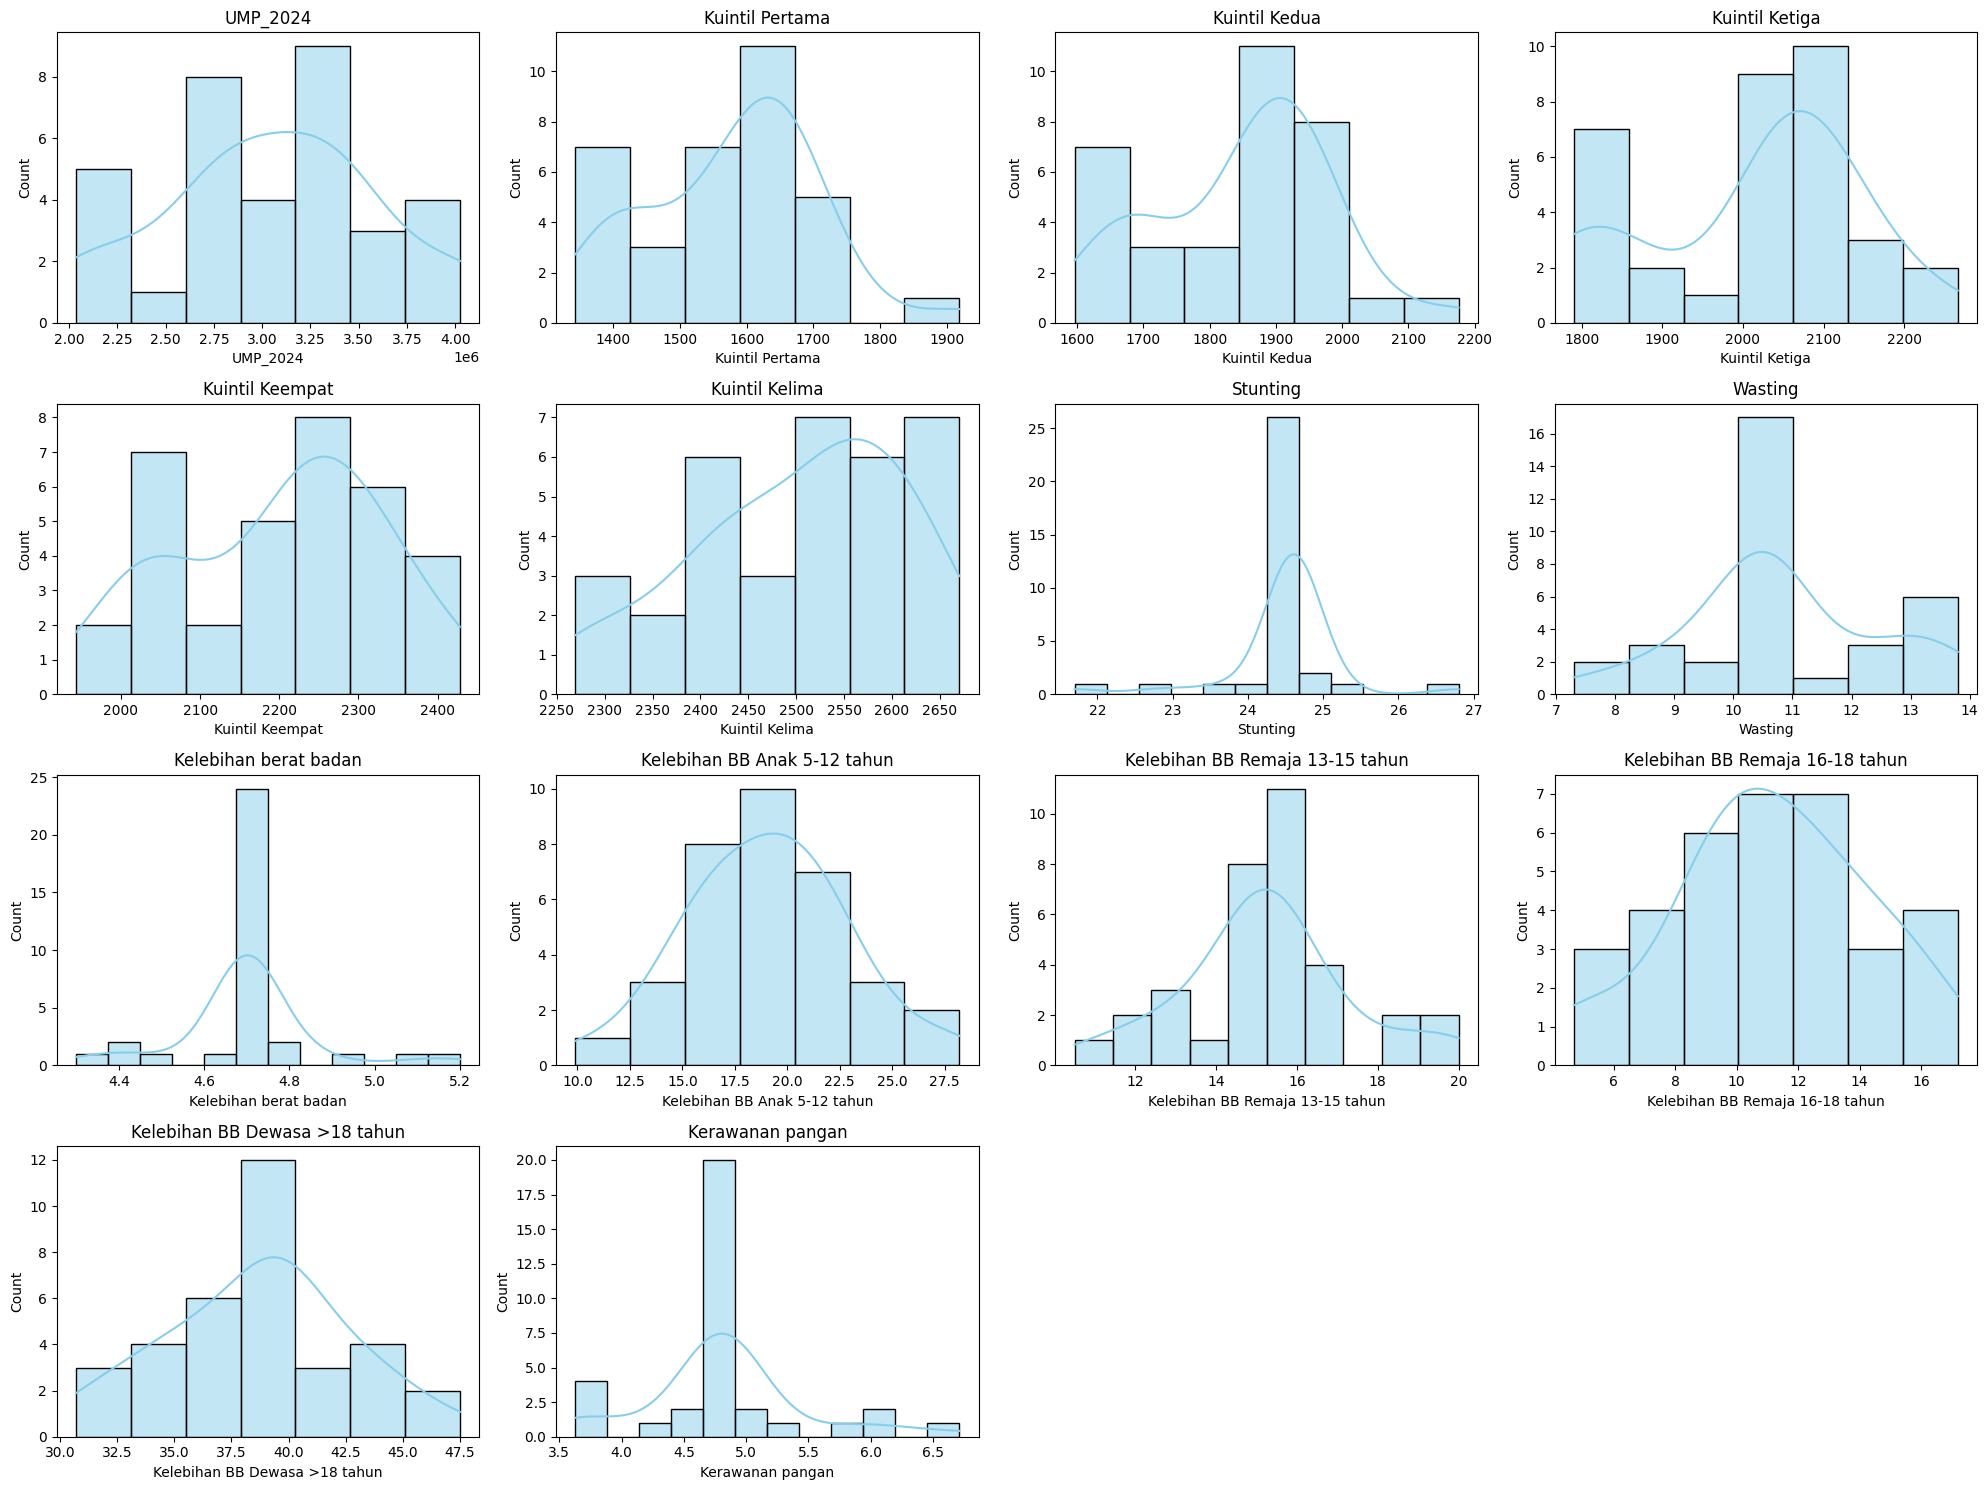

In [129]:
plt.figure(figsize=(20,15))
for i, col in enumerate(numeric_cols):
    plt.subplot(4,4,i+1)
    sns.histplot(df_eda[col], kde=True, color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.show()


## 4. Heatmap atau Korelasi Antar Variabel

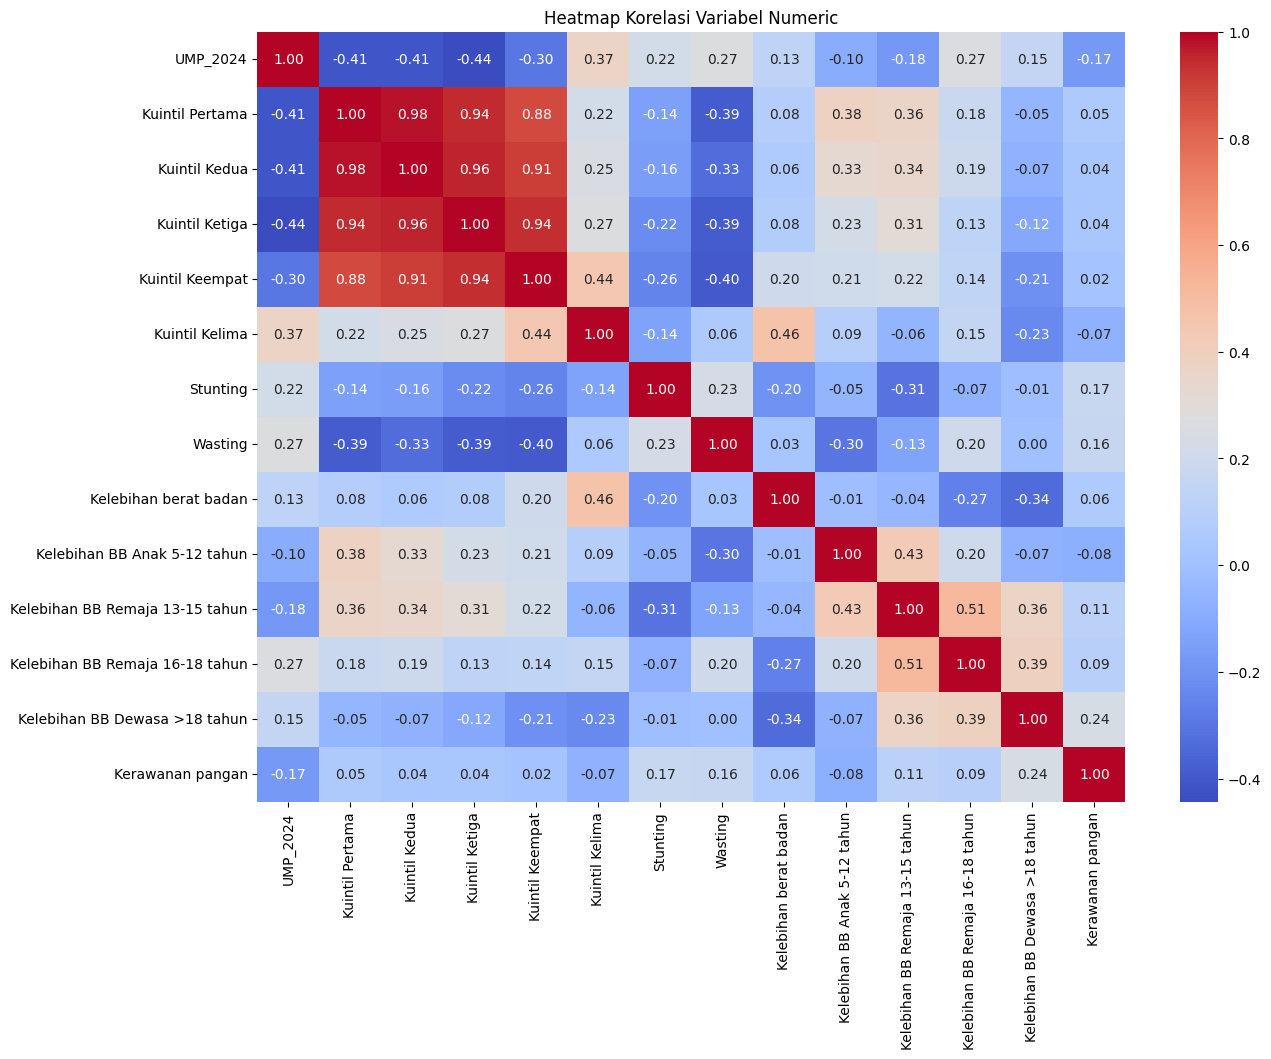

In [130]:
plt.figure(figsize=(14,10))
sns.heatmap(df_eda[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Heatmap Korelasi Variabel Numeric")
plt.show()


## 5. Analisis provinsi

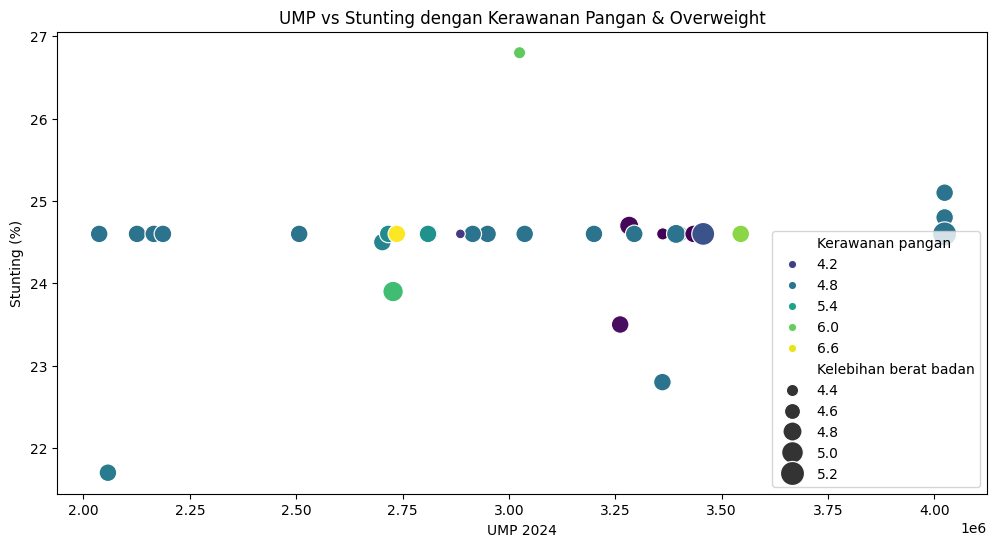

In [131]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=df_eda, x='UMP_2024', y='Stunting', hue='Kerawanan pangan', size='Kelebihan berat badan', palette='viridis', sizes=(50,300))
plt.title("UMP vs Stunting dengan Kerawanan Pangan & Overweight")
plt.xlabel("UMP 2024")
plt.ylabel("Stunting (%)")
plt.show()


## 6. Boxplot Tiap Kolom

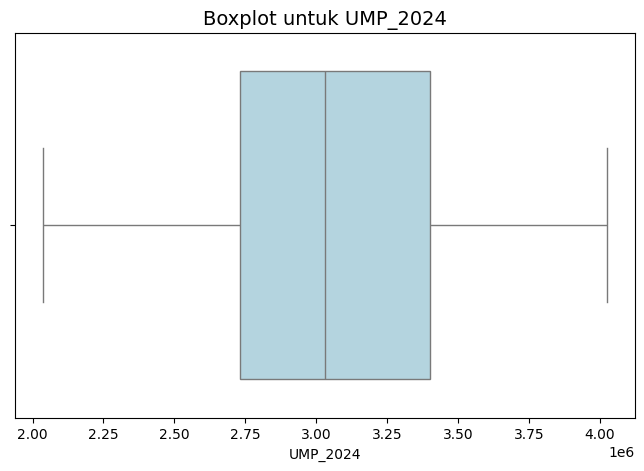

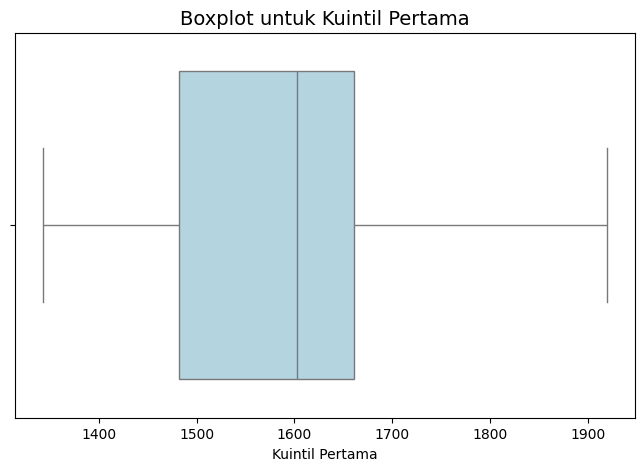

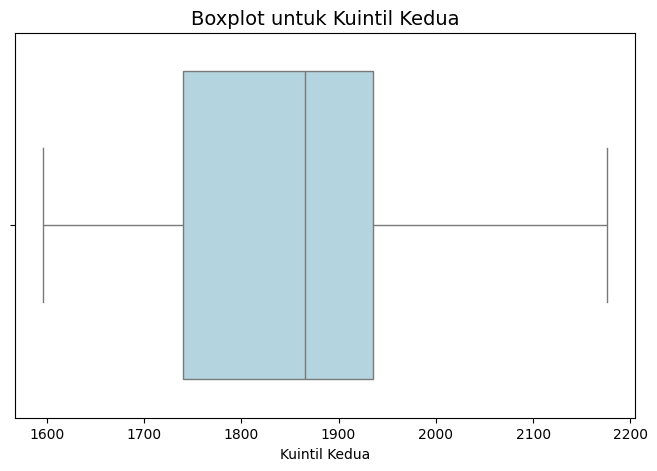

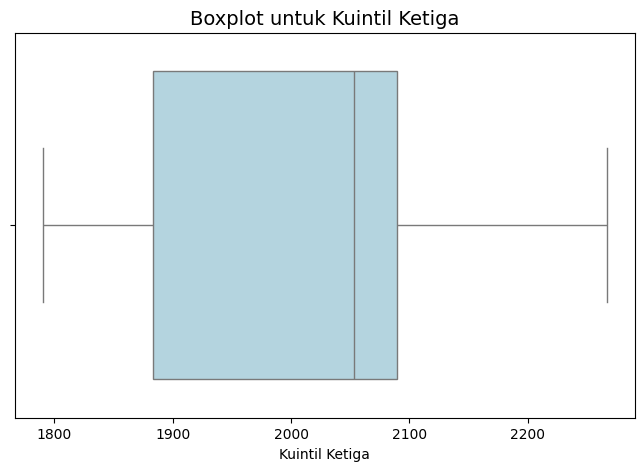

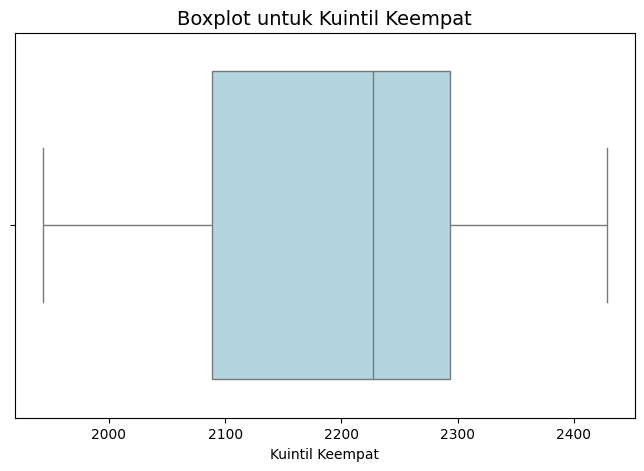

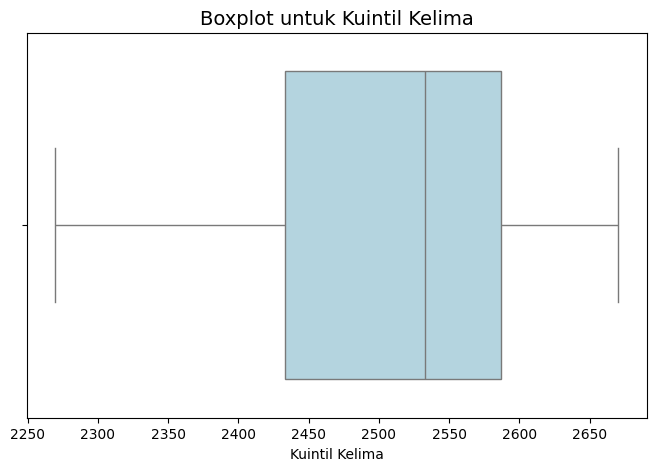

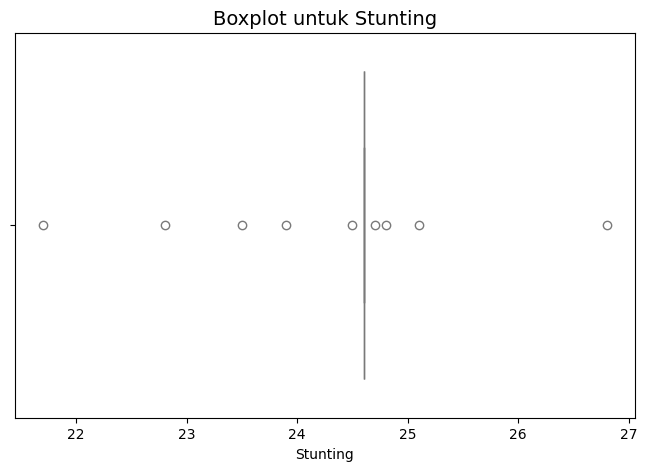

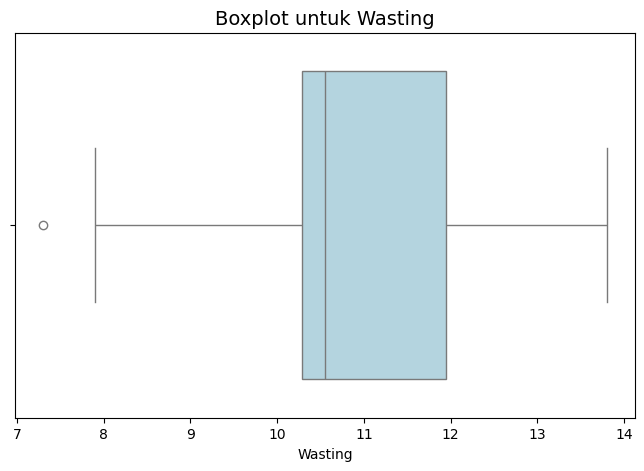

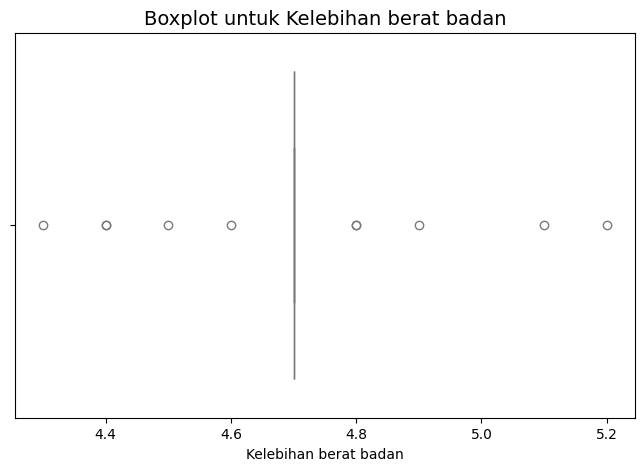

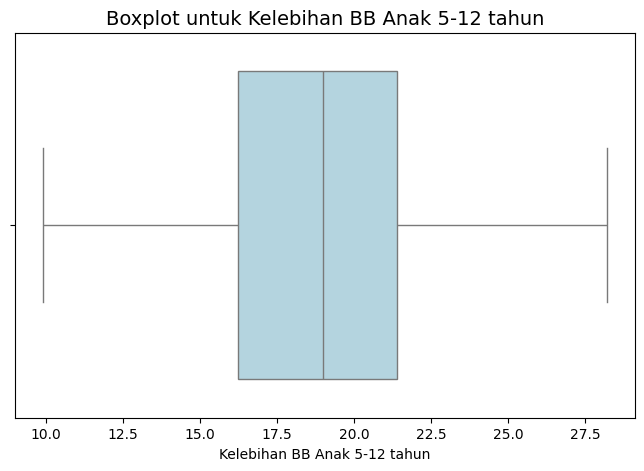

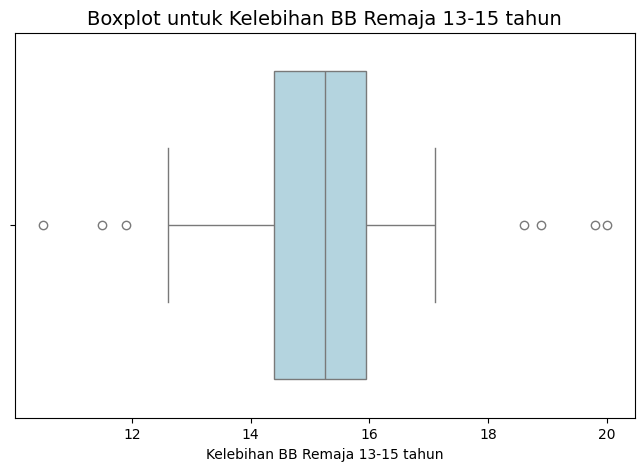

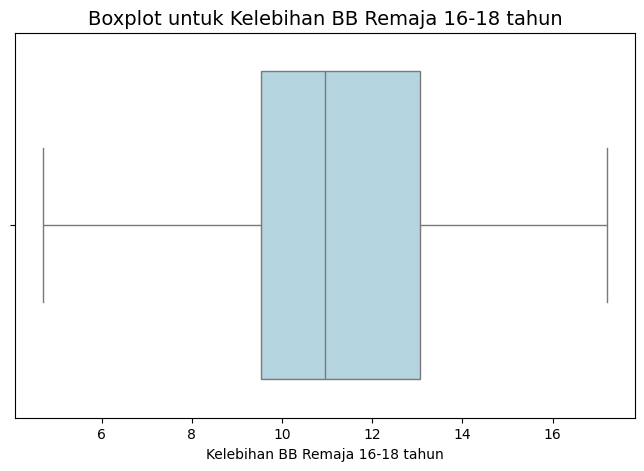

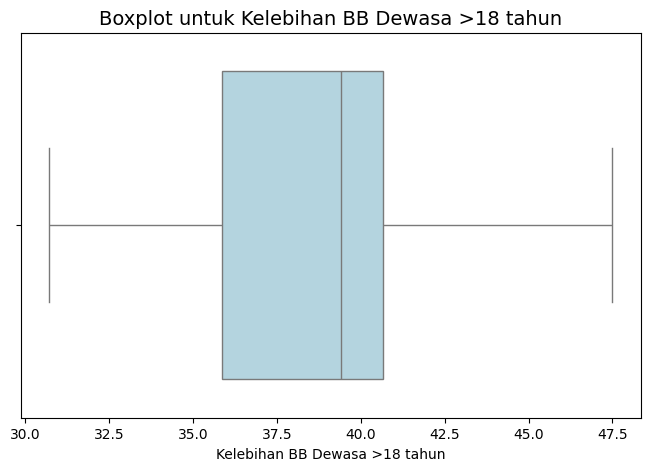

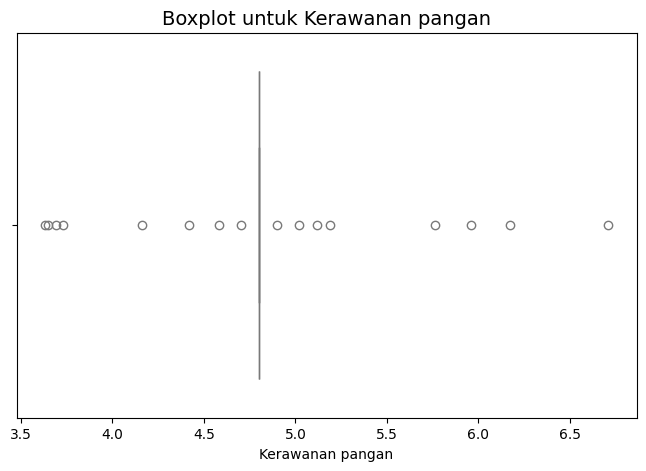

In [132]:
for col in numeric_cols:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=df_eda[col], color='lightblue')
    plt.title(f'Boxplot untuk {col}', fontsize=14)
    plt.xlabel(col)
    plt.show()

## 7. Pairplot / Scatterplot Matrix

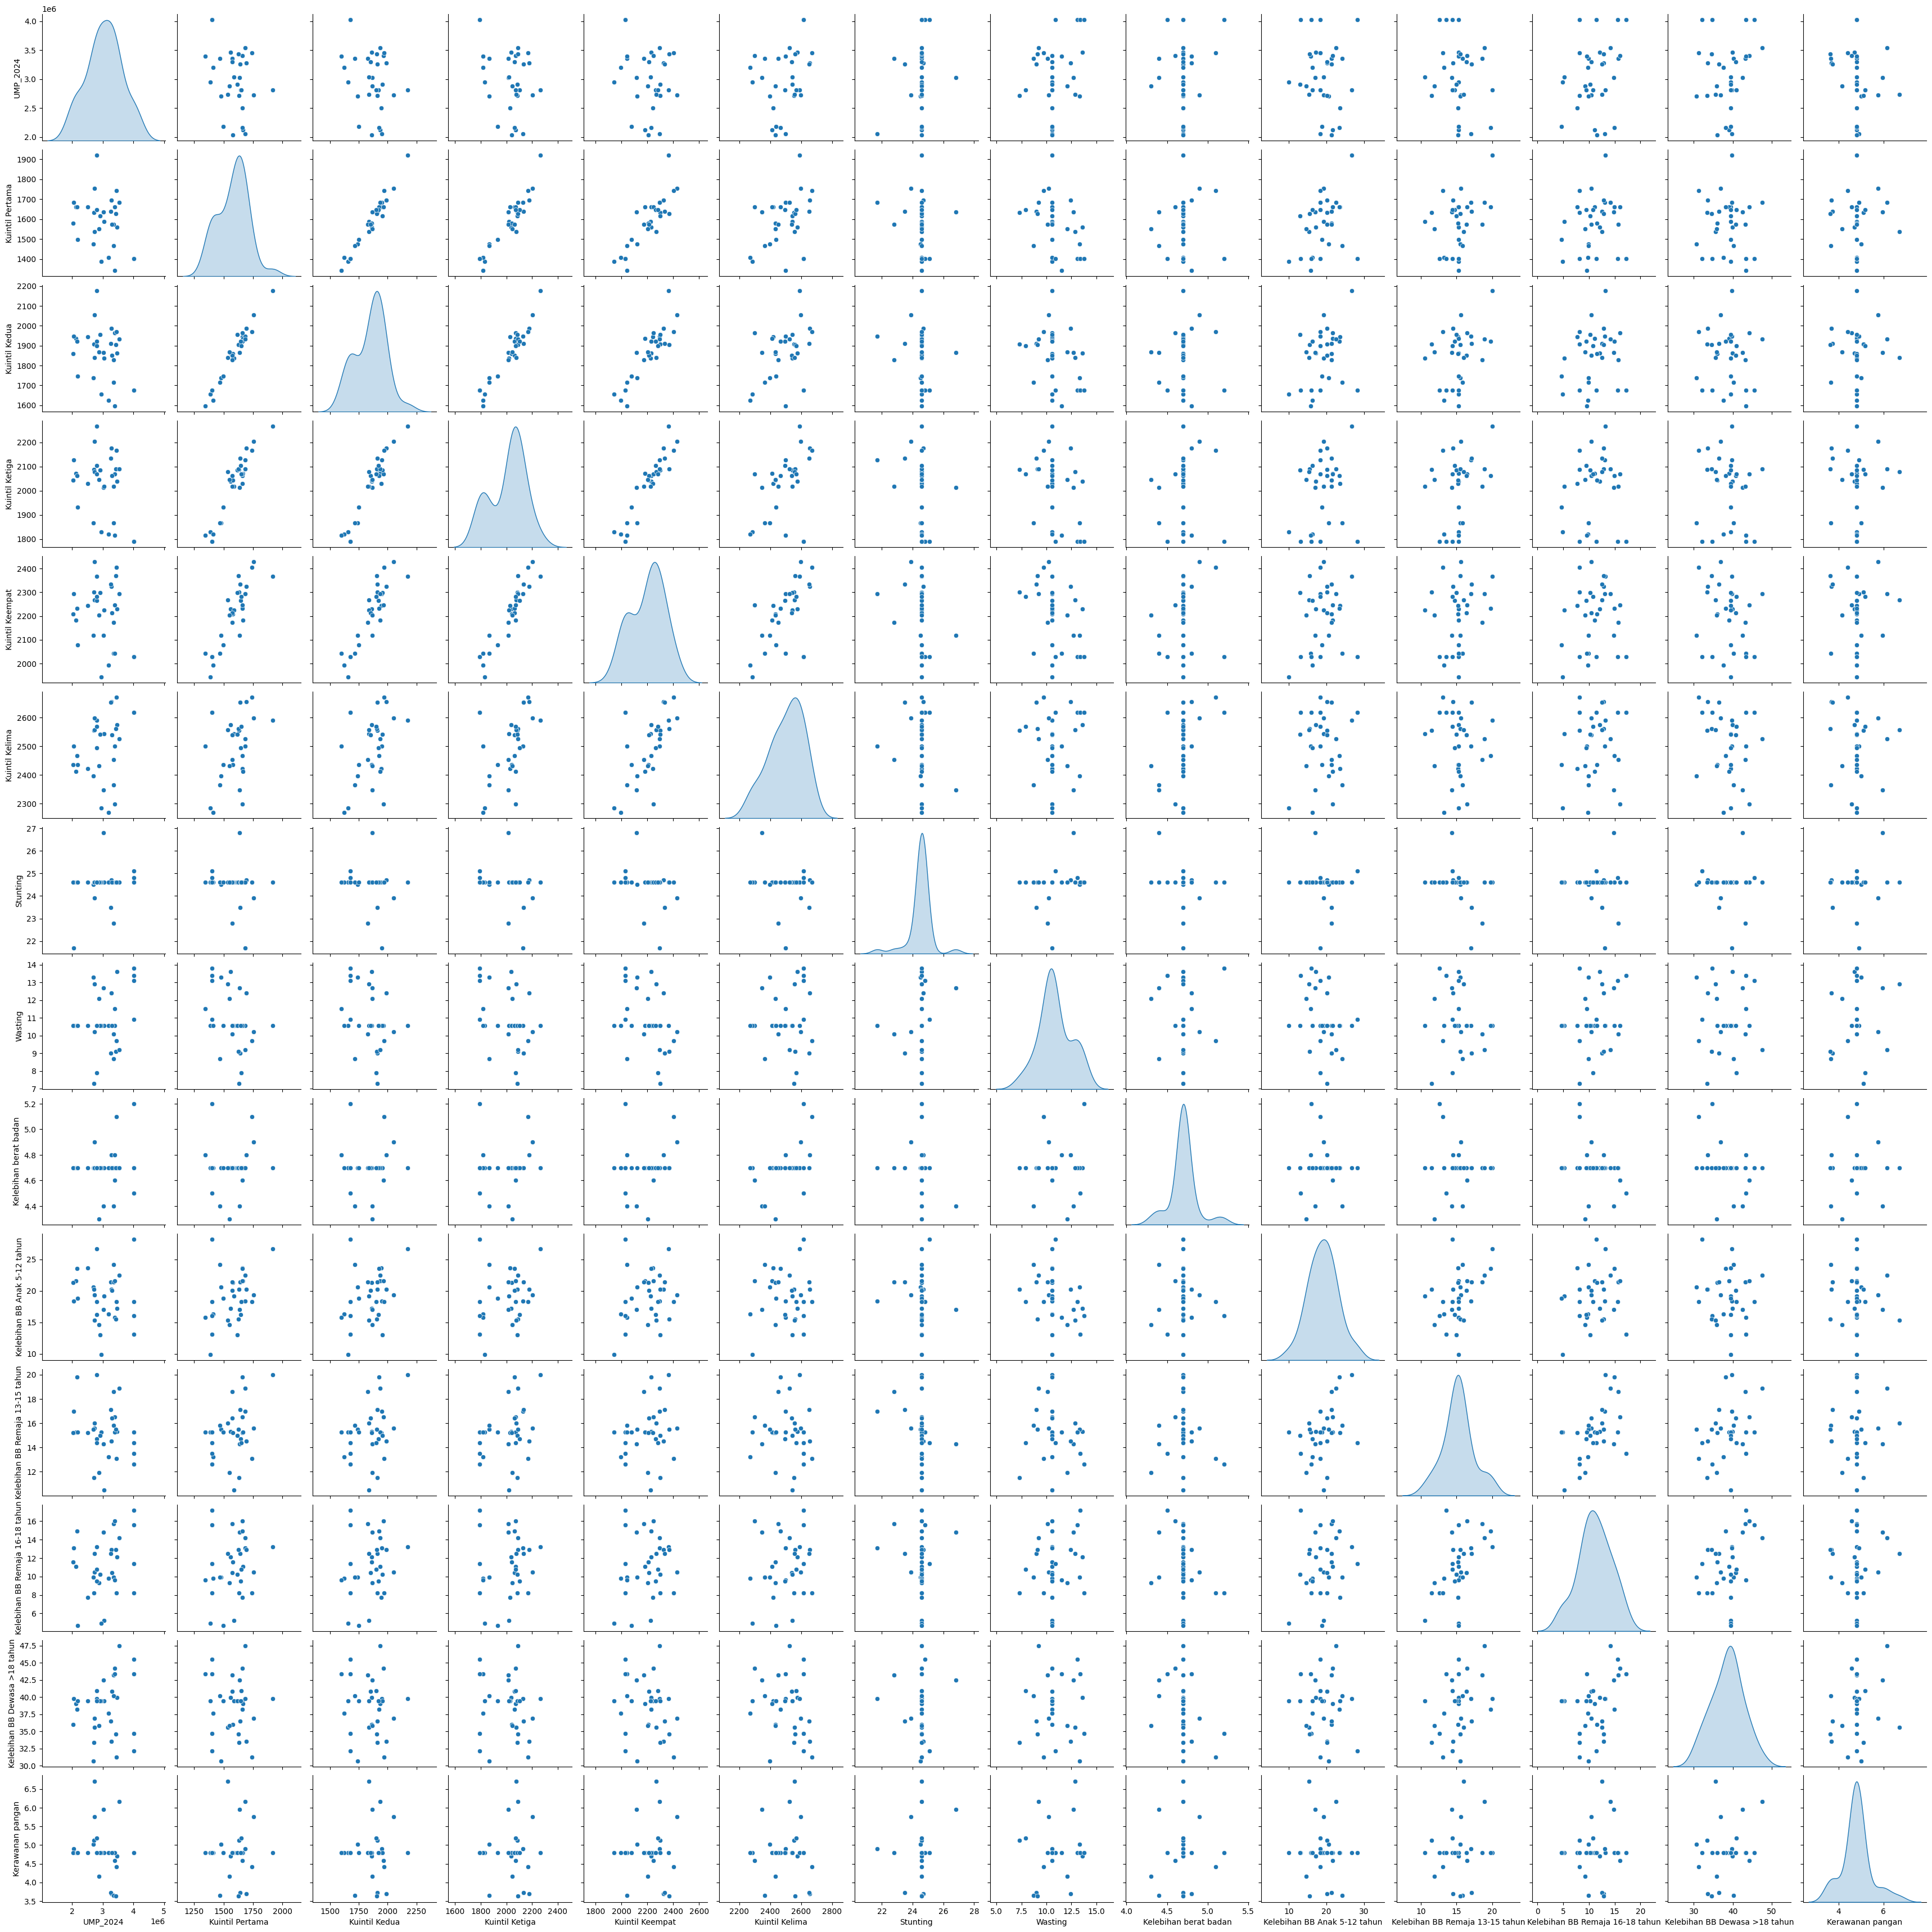

In [133]:
sns.pairplot(df_eda[numeric_cols], diag_kind='kde')
plt.show()


## 8. Barplot / Top-N Analisis

C:\Users\Salsabila Alika\AppData\Local\Temp\ipykernel_14716\103080647.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5, x=col, y='Provinsi', ax=axes[i], palette='viridis')
C:\Users\Salsabila Alika\AppData\Local\Temp\ipykernel_14716\103080647.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5, x=col, y='Provinsi', ax=axes[i], palette='viridis')
C:\Users\Salsabila Alika\AppData\Local\Temp\ipykernel_14716\103080647.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5, x=col, y='Provinsi', ax=axes[i], palette=

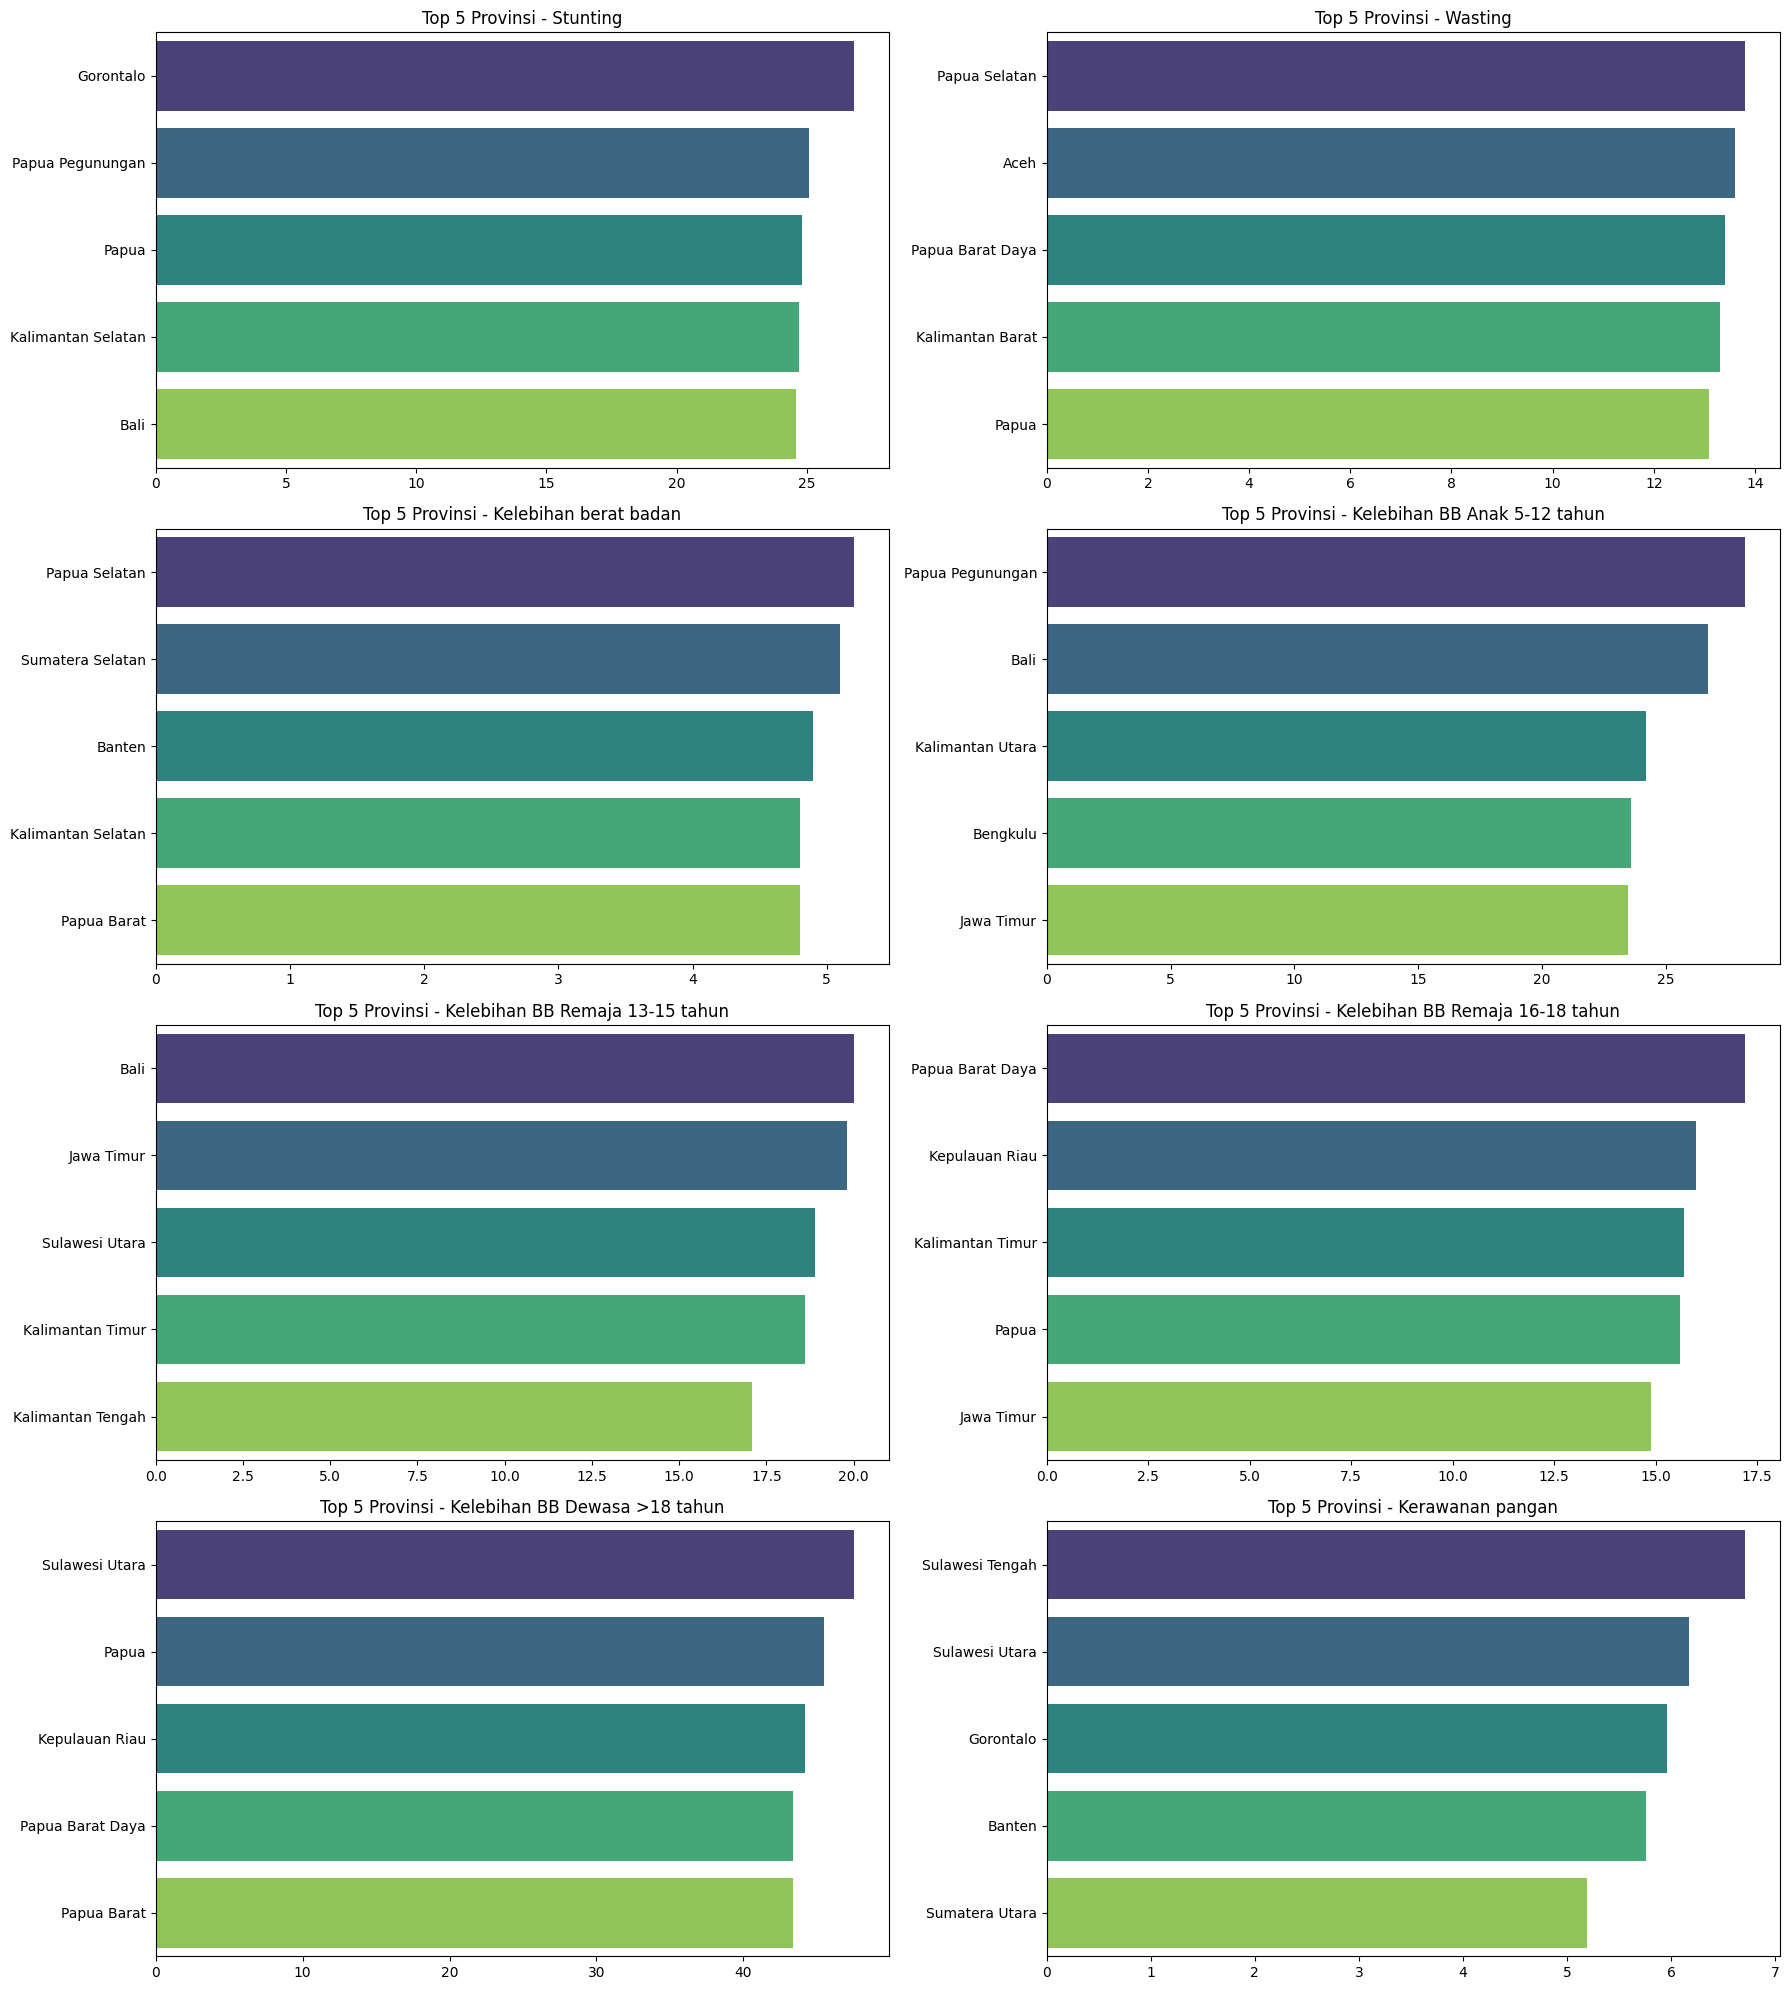

In [134]:
# Daftar indikator yang mau ditampilkan
metrics = ['Stunting', 'Wasting', 'Kelebihan berat badan', 
           'Kelebihan BB Anak 5-12 tahun', 'Kelebihan BB Remaja 13-15 tahun', 
           'Kelebihan BB Remaja 16-18 tahun', 'Kelebihan BB Dewasa >18 tahun', 
           'Kerawanan pangan']

fig, axes = plt.subplots(4, 2, figsize=(18, 20))
axes = axes.flatten()

for i, col in enumerate(metrics):
    # Ambil top 5 provinsi
    top5 = df_eda[['Provinsi', col]].sort_values(by=col, ascending=False).head(5)
    
    sns.barplot(data=top5, x=col, y='Provinsi', ax=axes[i], palette='viridis')
    axes[i].set_title(f'Top 5 Provinsi - {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()



# D. Data Publishing

In [137]:
df_ump.to_csv("raw_ump.csv", index=False)
df_clean_kalori.to_csv("raw_kalori.csv", index=False)
df_kesehatan.to_csv("raw_kesehatan.csv", index=False)
df_clean.to_csv("dataset_clean.csv", index=False)
